In [1]:
%reset -f

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = (10.0, 6.0)

In [3]:
import scipy.stats

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D

In [5]:
import collections

In [6]:
import pickle

In [7]:
import bridson

In [8]:
import sklearn.preprocessing
import sklearn.model_selection

In [9]:
import uproot
uproot.default_library = "np"

In [10]:
import os.path

In [11]:
import logging
logging.basicConfig(level=logging.INFO)

In [12]:
np.set_printoptions(precision=4, suppress=True)

In [13]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [14]:
def to_numpy(t):
    return t.detach().cpu().numpy()
def to_numpy_(*t_):
    return (to_numpy(t) for t in t_)
def from_numpy(t, dtype=torch.float, device=device):
    return torch.as_tensor(t, dtype=dtype, device=device)
def from_numpy_(*t_, dtype=torch.float, device=device):
    return (from_numpy(t, dtype=dtype, device=device) for t in t_)
def as_numpy(f, dtype=torch.float, device=device):
    return lambda *x: to_numpy(f(*from_numpy_(*x, dtype=dtype, device=device)))
def as_numpy_(f, dtype=torch.float, device=device):
    return lambda *x: to_numpy_(*f(*from_numpy_(*x, dtype=dtype, device=device)))

In [15]:
class Lambda(torch.nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x):
        return self.fn(x)

In [16]:
def clone_model(model, force_eval=True, set_to_none=True):
    if force_eval:
        model.eval()
    model.zero_grad(set_to_none=set_to_none)
    return pickle.loads(pickle.dumps(model))

### Data

In [17]:
class DataFile(object):
    def __init__(self, path, name, aliases={}):
        self.path = path
        self.name = name
        self.aliases = aliases
        self.raw = uproot.open(self.path)
    def features(self):
        return sorted(list(set(list(self.raw.keys()) + list(self.aliases.keys()))))
    def true_features(self):
        return [name for name in self.features() if "TRUE" in name]
    def __len__(self):
        return self.raw.num_entries
    def __item__(self, name):
        return self.raw[name].array(library="np")
    def get(self, features, aliases={}):
        res = self.raw.arrays(features, aliases=(self.aliases|aliases), library="np")
        array = np.empty((self.raw.num_entries, len(features)), dtype=float)
        for i, feature in enumerate(features):
            array[:,i] = res[feature]
        return array

In [18]:
channel_names = [
    r"B⁺→K⁺ee",
    r"B⁺→K⁺J/ψ(→ee)",
    r"B⁺→K⁺ψ(2S)(→ee)",
    r"D⁺→π⁺φ(→ee)",
]

In [19]:
tree_names = [
    "RapidSim/B2Kee_tree-2Dhits.root:DecayTree;27",
    "RapidSim/B2KJpsi2ee_tree-2Dhits.root:DecayTree;34",
    "RapidSim/B2Kpsi2s2ee_tree-2Dhits.root:DecayTree;35",
    "RapidSim/D2phipi2ee_tree-2Dhits.root:DecayTree;30",
]

In [20]:
basedir = os.path.expanduser("~/2021/")
files = [DataFile(os.path.join(basedir, path), name) for path, name in zip(tree_names, channel_names)]

In [21]:
files[3].aliases = {
    'B_FD_TRUE': "D_FD_TRUE",
}

In [22]:
def common_features(fs):
    return sorted(set.intersection(*[set(f.true_features()) for f in fs]))
common_features(files)

['B_FD_TRUE',
 'angle_ee_TRUE',
 'em_ET_TRUE',
 'em_E_TRUE',
 'em_IP_TRUE',
 'em_PT_TRUE',
 'em_PT_TRUE_',
 'em_PX_TRUE',
 'em_PY_TRUE',
 'em_PZ_TRUE',
 'em_P_TRUE',
 'em_SIGMAIP_TRUE',
 'em_eta_TRUE',
 'em_origX_TRUE',
 'em_origY_TRUE',
 'em_origZ_TRUE',
 'em_phi_TRUE',
 'ep_ET_TRUE',
 'ep_E_TRUE',
 'ep_IP_TRUE',
 'ep_PT_TRUE',
 'ep_PT_TRUE_',
 'ep_PX_TRUE',
 'ep_PY_TRUE',
 'ep_PZ_TRUE',
 'ep_P_TRUE',
 'ep_SIGMAIP_TRUE',
 'ep_eta_TRUE',
 'ep_origX_TRUE',
 'ep_origY_TRUE',
 'ep_origZ_TRUE',
 'ep_phi_TRUE',
 'q2_TRUE']

### Event selection

In [23]:
class SelectedData(object):
    def __init__(self, datafile, selector):
        assert selector.shape == (len(datafile), )
        self.datafile = datafile
        self.index = np.asarray(selector, dtype=bool)
        self.size = np.sum(self.index)
    def name(self):
        return self.datafile.name
    def get(self, features, aliases={}):
        return self.datafile.get(features, aliases=aliases)[self.index]
    def true_features(self):
        return self.datafile.true_features()
    def features(self):
        return self.datafile.features()
    def __len__(self):
        return self.size

In [24]:
def split(selected, **options):
    selector = selected.index
    arr = np.arange(len(selector))[selector]
    train_index, test_index = sklearn.model_selection.train_test_split(arr, **options)
    train_selector = np.zeros_like(selector, dtype=bool)
    test_selector = np.zeros_like(selector, dtype=bool)
    train_selector[train_index] = True
    test_selector[test_index] = True
    train = SelectedData(selected.datafile, train_selector)
    test = SelectedData(selected.datafile, test_selector)
    return train, test

In [25]:
def join_and(*conditions):
    return "&".join(["(%s)"%condition for condition in conditions])
def q2_range(v1, v2):
    return join_and("q2_TRUE > %g" % v1, "q2_TRUE < %g" % v2)

In [26]:
q_Kll_selector = q2_range(1.1, 6.0)
q_Jpsi_e_selector = q2_range(6.0, 12.96)
q_Jpsi_mu_selector = q2_range(8.68, 10.09)
q_psi2S_e_selector = q2_range(9.82, 16.40)
q_psi2S_mu_selector = q2_range(12.5, 14.2)

In [27]:
selectors = [
    q_Kll_selector,
    q_Jpsi_e_selector,
    q_psi2S_e_selector,
    "True",
]

In [28]:
selected = [SelectedData(f, f.get([selector])[:,0]) for f, selector in zip(files, selectors)]

In [29]:
splitted = [split(f, shuffle=True, test_size=0.2) for f in selected]
train_ds = [x[0] for x in splitted]
test_ds = [x[1] for x in splitted]

In [30]:
df = pd.DataFrame(index=channel_names)
#df.index.name = "Channels"
df.columns.name = "#Events"
df["Total"] = None
df["Selected"] = None
df["Train"] = None
df["Test"] = None
for f in files:
    df.loc[f.name, "Total"] = len(f)
for f in selected:
    df.loc[f.name(), "Selected"] = len(f)
for f in train_ds:
    df.loc[f.name(), "Train"] = len(f)
for f in test_ds:
    df.loc[f.name(), "Test"] = len(f)
df["Selected/Total"] = df["Selected"] / df["Total"]
df

#Events           Total Selected   Train    Test Selected/Total
B⁺→K⁺ee          955868   243424  194739   48685       0.254663
B⁺→K⁺J/ψ(→ee)    946366   916346  733076  183270       0.968279
B⁺→K⁺ψ(2S)(→ee)  972093   926218  740974  185244       0.952808
D⁺→π⁺φ(→ee)      822647   822647  658117  164530            1.0

### KS tests

In [31]:
def perform_ks_test(datasets, selected_index):
    selected_dataset = datasets[selected_index]
    df_ks = pd.DataFrame()
    #df_ks.index.name = "Features"
    df_ks.columns.name = "KS test"
    for feature in selected_dataset.features():
        arr0 = selected_dataset.get([feature])[:,0]
        for index, arr in enumerate(datasets):
            if index == selected_index:
                continue
            if not feature in arr.features():
                continue
            arr1 = arr.get([feature])[:,0]
            df_ks.loc[feature, arr.name()] = scipy.stats.kstest(arr0,arr1).statistic
    return df_ks

In [32]:
perform_ks_test(train_ds, 0).style.applymap(lambda x: "background-color: yellow" if x > 0.05 else None)

### Plots

In [33]:
def feature_plot(feature, datasets, aliases={}, bins=None, **kwargs):
    for f in datasets:
        try:
            plt.hist(f.get([feature], aliases=aliases), label="%s"%f.name(),
                density=True, histtype='step', bins=bins, **kwargs)
        except:
            pass
    plt.title(feature)
    plt.legend()
    plt.grid()
    plt.show()

In [34]:
aliases = {
    "min_e_IP": "fmin(ep_IP_TRUE,em_IP_TRUE)",
    "max_e_PT": "fmax(ep_PT_TRUE,em_PT_TRUE)",
    "max_e_SIGMAIP": "fmax(ep_SIGMAIP_TRUE,em_SIGMAIP_TRUE)",
    "log_ep_P": "log(ep_P_TRUE)",
    "log_em_P": "log(em_P_TRUE)",
    "log_max_pl": "fmax(log_ep_P,log_em_P)",    
}

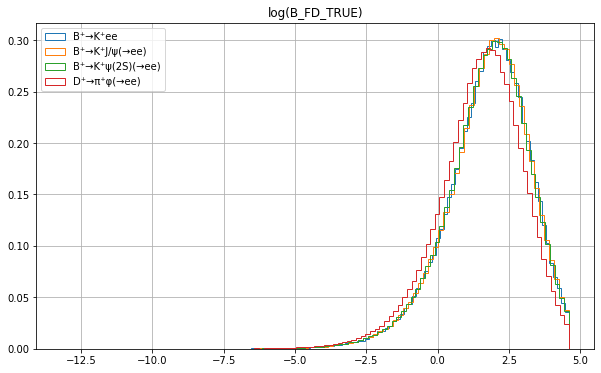

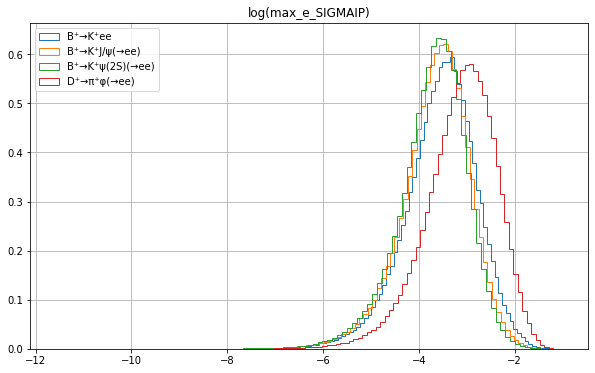

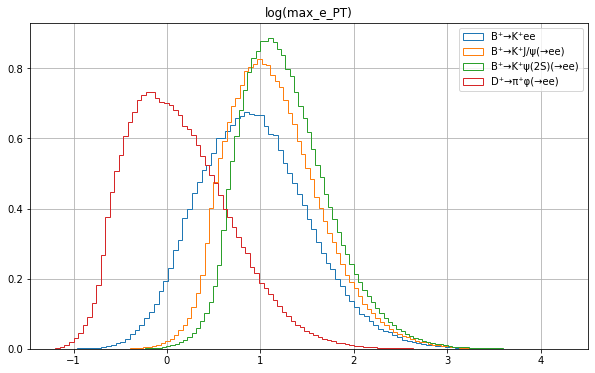

In [35]:
feature_plot("log(B_FD_TRUE)", train_ds, aliases, 101)
feature_plot("log(max_e_SIGMAIP)", train_ds, aliases, 101)
feature_plot("log(angle_ee_TRUE)", train_ds, aliases, 101)
feature_plot("log(min_e_IP)", train_ds, aliases, 101)
feature_plot("log(max_e_PT)", train_ds, aliases, 101)
feature_plot("log_max_pl", train_ds, aliases, 101)

### Preprocessing

In [36]:
class Loader(object):
    def __init__(self, dataset, batch_size=1, shuffle=True, drop_last=False, device=None):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.device = device
    def __len__(self):
        data_len = len(self.dataset)
        if self.drop_last:
            off = 0
        else:
            off = self.batch_size - 1
        return (data_len + off) // self.batch_size
    def __iter__(self):
        data_len = len(self.dataset)
        indices = torch.randperm(data_len, device=self.device) if self.shuffle else None
        for i in range(0, data_len, self.batch_size):
            i_last = i + self.batch_size
            if (i_last > data_len):
                if self.drop_last:
                    break
                else:
                    i_last = data_len
            slc = slice(i, i_last)
            if indices is not None:
                yield self.dataset[indices[slc]]
            else:
                yield self.dataset[slc]

In [37]:
class Dataset(object):
    def __init__(self, features, sources, aliases={}, name=None):
        self.sources = sources
        self.features = features
        self.name = name
        self.counts = np.asarray([len(source) for source in self.sources])
        self.size = np.sum(self.counts)
        self.weights = self.size/self.counts/self.counts.size
        self.aliases = aliases
    def __len__(self):
        return np.sum(self.counts)
    def __repr__(self):
        return "DS%s" % self.name
    def X(self, **kwargs):
        ccounts = np.cumsum(self.counts)
        lower = ccounts - self.counts
        result = torch.empty(ccounts[-1], len(self.features), **kwargs)
        for i in range(ccounts.size):
            np_data = self.sources[i].get(self.features, aliases=self.aliases)
            result[lower[i]:ccounts[i]] = torch.as_tensor(np_data, **kwargs)
        return result        
    def Y(self, **kwargs):
        ccounts = np.cumsum(self.counts)
        result = torch.zeros(ccounts[-1], **kwargs)
        for i in range(1, ccounts.size):
            result[ccounts[i-1]:ccounts[i]] = i
        return result
    def Y_hot(self):
        ccounts = np.cumsum(self.counts)
        result = torch.zeros(ccounts[-1], ccounts.size, **kwargs)
        for i in range(1, ccounts.size):
            result[ccounts[i-1]:ccounts[i], i] = 0
        return result

In [38]:
feature_sets = [
    ("α,p", ["angle_ee_TRUE", "log_max_pl"]),
    ("4", ["log(B_FD_TRUE)", "log(angle_ee_TRUE)", "log(min_e_IP)", "log(max_e_PT)"]),
    ("5", ["log(B_FD_TRUE)", "log(angle_ee_TRUE)", "log(min_e_IP)", "log(max_e_PT)", "log(max_e_SIGMAIP)"]),
]
train_datasets = [
    ("₄", train_ds),
    ("₃", train_ds[:3]),
]

all_datasets = list()
for f in feature_sets:
    for t in train_datasets:
        all_datasets.append(Dataset(f[1], t[1], aliases, "%s[%s]"%(t[0],f[0])))
all_datasets

[DS₄[α,p], DS₃[α,p], DS₄[4], DS₃[4], DS₄[5], DS₃[5]]

In [39]:
class Scaler(torch.nn.Module):
    def __init__(self, dataset):
        super().__init__()
        self.features = dataset.features
        self.scaler = sklearn.preprocessing.StandardScaler()
        self.minmax = sklearn.preprocessing.MinMaxScaler()
        x = to_numpy(dataset.X())
        self.scaler.fit(x)
        self.minmax.fit(x)
        self.mu = torch.as_tensor(self.scaler.mean_, dtype=float, device=device)
        self.sigma = torch.as_tensor(self.scaler.scale_, dtype=float, device=device)
        self.min = self.minmax.data_min_
        self.max = self.minmax.data_max_
    def forward(self, data):
        return ((data-self.mu)/self.sigma).float()
    def transform(self, x):
        return self.scaler.transform(x)
    def inverse_transform(self, x):
        return self.scaler.inverse_transform(x)

In [40]:
def plot_ds(dataset, scaler=None, ax=None, scale=3.0):
    sc = Scaler(dataset) if scaler is None else scaler
    axis = plt.gca() if ax is None else ax
    for source in dataset.sources:
        x = source.get(dataset.features, dataset.aliases)[:10000,0:2]
        axis.scatter(*(x.T), marker=".", s=0.1, label="%s"%source.name())
    upper = np.repeat(scale, 2)[None,:]
    lower = -upper
    x_min, y_min = sc.min # sc.inverse_transform(lower)[0]
    x_max, y_max = sc.max # sc.inverse_transform(upper)[0]
    axis.set_xlabel(dataset.features[0])
    axis.set_ylabel(dataset.features[1])
    axis.set_xlim(x_min, x_max)
    axis.set_ylim(y_min, y_max)
    axis.set_aspect(1.0/axis.get_data_ratio(), adjustable='box')
    axis.set_title("DS%s"%dataset.name)
    
    def update_prop(handle, orig):
        handle.update_from(orig)
        handle.set_sizes([3.0])
        handle.set_linewidth(3.0)
        
    axis.legend(handler_map={
        mpl.collections.PathCollection:mpl.legend_handler.HandlerPathCollection(update_func=update_prop),
    })
    axis.grid()
    if ax is None:
        plt.show()

In [41]:
#fig, ax = plt.subplots(3, 2, figsize=(10, 15))
#for i in range(6):
#    plot_ds(all_datasets[i], scale=2.0, ax=ax[i//2,i%2])
#plt.show()

### NN

In [42]:
def model(inputs, outputs):
    return nn.Sequential(
        nn.Linear(inputs, 20), nn.Softplus(),
        nn.Linear(20, 20), nn.Softplus(),
        nn.Linear(20, 20), nn.Softplus(),
        nn.Linear(20, outputs),
    )

In [43]:
def train(model, loader, epochs=20, weight=None, accumulate=False):
    total_count = len(loader.dataset)
    model.train()
    model.zero_grad()
    opt = torch.optim.Adam(params=model.parameters())
    opt.zero_grad()
    wt = from_numpy(weight) if weight is not None else None
    for epoch in range(epochs):
        total_loss = 0
        for batch in loader:
            x, y = batch
            pred = model(x)
            loss = F.cross_entropy(
                input=pred,
                target=y,
                weight=wt,
                reduction='sum',
            )
            total_loss += loss
            count = x.shape[0] if not accumulate else total_count
            loss /= count
            loss.backward()
            if not accumulate:
                opt.step()
                opt.zero_grad()
        mean_loss = total_loss / total_count
        if accumulate:
            opt.step()
            opt.zero_grad()
        logging.info("Epoch %d, %f", epoch, mean_loss)
    model.eval()
    model.zero_grad(set_to_none=True)

### Weight limits estimation

In [44]:
def train_estimator(dataset, model, device=device):
    model.to(device)
    ds = torch.utils.data.TensorDataset(
        dataset.X(device=device, dtype=float),
        dataset.Y(device=device, dtype=torch.int64)
    )
    loader = Loader(ds, batch_size=100000, shuffle=True, device=device)
    train(model, loader, epochs=50, weight=dataset.weights, accumulate=False)
    loader = Loader(ds, batch_size=100000, shuffle=False, device=device)
    train(model, loader, epochs=50, weight=dataset.weights, accumulate=True)
    return model.eval()

In [45]:
def make_estimator(dataset, device=device):
    scaler = Scaler(dataset)
    m = model(len(dataset.features), len(dataset.sources))
    return torch.nn.Sequential(scaler, m).to(device)

In [46]:
%%time
all_est = list()
for ds in all_datasets:
    est = make_estimator(ds)
    train_estimator(ds, est)
    all_est.append(est)
all_est

INFO:root:Epoch 0, 1.383914
INFO:root:Epoch 1, 1.365469
INFO:root:Epoch 2, 1.326080
INFO:root:Epoch 3, 1.229373
INFO:root:Epoch 4, 1.085245
INFO:root:Epoch 5, 1.002526
INFO:root:Epoch 6, 0.959336
INFO:root:Epoch 7, 0.927064
INFO:root:Epoch 8, 0.908873
INFO:root:Epoch 9, 0.901500
INFO:root:Epoch 10, 0.897863
INFO:root:Epoch 11, 0.894982
INFO:root:Epoch 12, 0.892214
INFO:root:Epoch 13, 0.889396
INFO:root:Epoch 14, 0.886399
INFO:root:Epoch 15, 0.883195
INFO:root:Epoch 16, 0.879779
INFO:root:Epoch 17, 0.876221
INFO:root:Epoch 18, 0.872467
INFO:root:Epoch 19, 0.868581
INFO:root:Epoch 20, 0.864733
INFO:root:Epoch 21, 0.860830
INFO:root:Epoch 22, 0.857101
INFO:root:Epoch 23, 0.853687
INFO:root:Epoch 24, 0.850596
INFO:root:Epoch 25, 0.847888
INFO:root:Epoch 26, 0.845561
INFO:root:Epoch 27, 0.843498
INFO:root:Epoch 28, 0.841688
INFO:root:Epoch 29, 0.840027
INFO:root:Epoch 30, 0.838422
INFO:root:Epoch 31, 0.836998
INFO:root:Epoch 32, 0.835495
INFO:root:Epoch 33, 0.834170
INFO:root:Epoch 34, 0.83

INFO:root:Epoch 35, 0.943507
INFO:root:Epoch 36, 0.943411
INFO:root:Epoch 37, 0.943327
INFO:root:Epoch 38, 0.943266
INFO:root:Epoch 39, 0.943206
INFO:root:Epoch 40, 0.943127
INFO:root:Epoch 41, 0.943038
INFO:root:Epoch 42, 0.942960
INFO:root:Epoch 43, 0.942895
INFO:root:Epoch 44, 0.942826
INFO:root:Epoch 45, 0.942745
INFO:root:Epoch 46, 0.942661
INFO:root:Epoch 47, 0.942586
INFO:root:Epoch 48, 0.942517
INFO:root:Epoch 49, 0.942442
INFO:root:Epoch 0, 1.165680
INFO:root:Epoch 1, 1.098810
INFO:root:Epoch 2, 1.095948
INFO:root:Epoch 3, 1.092040
INFO:root:Epoch 4, 1.087615
INFO:root:Epoch 5, 1.079761
INFO:root:Epoch 6, 1.065308
INFO:root:Epoch 7, 1.040472
INFO:root:Epoch 8, 1.009048
INFO:root:Epoch 9, 0.989437
INFO:root:Epoch 10, 0.982293
INFO:root:Epoch 11, 0.977009
INFO:root:Epoch 12, 0.972602
INFO:root:Epoch 13, 0.968811
INFO:root:Epoch 14, 0.965469
INFO:root:Epoch 15, 0.962465
INFO:root:Epoch 16, 0.959740
INFO:root:Epoch 17, 0.957146
INFO:root:Epoch 18, 0.954703
INFO:root:Epoch 19, 0.95

INFO:root:Epoch 20, 0.921077
INFO:root:Epoch 21, 0.921077
INFO:root:Epoch 22, 0.921023
INFO:root:Epoch 23, 0.920964
INFO:root:Epoch 24, 0.920929
INFO:root:Epoch 25, 0.920898
INFO:root:Epoch 26, 0.920856
INFO:root:Epoch 27, 0.920819
INFO:root:Epoch 28, 0.920803
INFO:root:Epoch 29, 0.920782
INFO:root:Epoch 30, 0.920733
INFO:root:Epoch 31, 0.920675
INFO:root:Epoch 32, 0.920639
INFO:root:Epoch 33, 0.920623
INFO:root:Epoch 34, 0.920598
INFO:root:Epoch 35, 0.920552
INFO:root:Epoch 36, 0.920505
INFO:root:Epoch 37, 0.920471
INFO:root:Epoch 38, 0.920439
INFO:root:Epoch 39, 0.920401
INFO:root:Epoch 40, 0.920364
INFO:root:Epoch 41, 0.920329
INFO:root:Epoch 42, 0.920291
INFO:root:Epoch 43, 0.920247
INFO:root:Epoch 44, 0.920206
INFO:root:Epoch 45, 0.920173
INFO:root:Epoch 46, 0.920138
INFO:root:Epoch 47, 0.920095
INFO:root:Epoch 48, 0.920051
INFO:root:Epoch 49, 0.920012


CPU times: user 3min 4s, sys: 13.1 s, total: 3min 17s
Wall time: 3min 16s


[Sequential(
   (0): Scaler()
   (1): Sequential(
     (0): Linear(in_features=2, out_features=20, bias=True)
     (1): Softplus(beta=1, threshold=20)
     (2): Linear(in_features=20, out_features=20, bias=True)
     (3): Softplus(beta=1, threshold=20)
     (4): Linear(in_features=20, out_features=20, bias=True)
     (5): Softplus(beta=1, threshold=20)
     (6): Linear(in_features=20, out_features=4, bias=True)
   )
 ),
 Sequential(
   (0): Scaler()
   (1): Sequential(
     (0): Linear(in_features=2, out_features=20, bias=True)
     (1): Softplus(beta=1, threshold=20)
     (2): Linear(in_features=20, out_features=20, bias=True)
     (3): Softplus(beta=1, threshold=20)
     (4): Linear(in_features=20, out_features=20, bias=True)
     (5): Softplus(beta=1, threshold=20)
     (6): Linear(in_features=20, out_features=3, bias=True)
   )
 ),
 Sequential(
   (0): Scaler()
   (1): Sequential(
     (0): Linear(in_features=4, out_features=20, bias=True)
     (1): Softplus(beta=1, threshold=20)
 

In [47]:
def plot_field(f, sc, scale=3.0, name=None, vmin=0.0, vmax=1.0, ax=None, color_bar=True):
    axis = plt.gca() if ax is None else ax
    
    x_min, y_min = sc.min
    x_max, y_max = sc.max
    
    x1, y1 = sc.transform([[x_min, y_min]])[0]
    x2, y2 = sc.transform([[x_max, y_max]])[0]
    
    X_test = sc.inverse_transform(
        np.asarray(bridson.poisson_disc_samples(x2-x1, y2-y1, 0.02)) +
        np.asarray([x1, y1])
    )
    
    y_pred = f(X_test).ravel()
    xi = np.linspace(x_min, x_max, 301)
    yi = np.linspace(y_min, y_max, 301)
    zi = scipy.interpolate.griddata(X_test, y_pred, tuple(np.meshgrid(xi, yi)), method='linear')
    CS = axis.contourf(xi, yi, zi, 20, cmap=plt.cm.seismic,
                      vmax=vmax, vmin=vmin)
    if color_bar:
        plt.colorbar(ax=axis, mappable=CS)
    axis.set_xlim(x_min, x_max)
    axis.set_ylim(y_min, y_max)
    axis.set_xlabel(sc.features[0])
    axis.set_ylabel(sc.features[1])
    axis.grid()
    axis.set_aspect(1.0/axis.get_data_ratio(), adjustable='box')
    if name is not None:
        axis.set_title(name)
    if ax is None:
        plt.show()

In [48]:
def plot_one(f, sc, name=None, save=None, vmin=0.0, vmax=1.0, ax=None):
    axis = plt.gca() if ax is None else ax
    x_min, x_max = sc.min, sc.max
    X_test = np.linspace(x_min, x_max, 1001)
    y_pred = f(X_test).ravel()
    axis.plot(X_test, y_pred)
    axis.set_xlim(x_min, x_max)
    axis.set_ylim(vmin, vmax)
    axis.set_xlabel(sc.features[0])
    axis.grid()    
    if name is not None:
        axis.set_title(name)
    if ax is None:
        plt.show()

In [49]:
def plot_clf(clf, scaler, c0, c1, ax=None, scale=3.0, color_bar=True):
    fn = lambda x : x[:,c1] - x[:,c0]
    f_ = lambda x : torch.sigmoid(fn(clf(x)))
    f = ds.as_numpy(f_)
    name=r'$\sigma\left(\log\frac{p(x|%s)}{p(x|%s)}\right)$'%(df_index[ds.mapping[c1]],df_index[ds.mapping[c0]])
    plot_field(f, scaler, scale=scale, ax=ax, name=name, color_bar=color_bar)

In [50]:
def plot_clf_min_max(clf, ax_min=None, ax_max=None, scale=3.0):
    fn = lambda x : x[...,1:] - x[...,0:1]
    f_min = lambda x : torch.relu(torch.min(fn(clf(x)), dim=-1)[0])
    f_max = lambda x : torch.relu(torch.min(-fn(clf(x)), dim=-1)[0])
    name_min = r'$\min_i\left(\log\frac{p(x|c_i)}{p(x|c)}\right)_+$'
    name_max = r'$\min_i\left(\log\frac{p(x|c)}{p(x|c_i)}\right)_+$'
    plot_field(as_numpy(f_min), clf[0], scale=scale, name=name_min, vmax=None, ax=ax_min, color_bar=False)
    plot_field(as_numpy(f_max), clf[0], scale=scale, name=name_max, vmax=None, ax=ax_max, color_bar=False)

In [51]:
if False:
    fig, ax = plt.subplots(6, 3, figsize=(15, 30))
    for i in range(6):
        est = all_est[i]
        ds = all_datasets[i]
        plot_ds(ds, scaler=est[0], ax=ax[i,0])
        plot_clf_min_max(est, ax_min=ax[i,1], ax_max=ax[i,2])
    plt.show()

### Weighting function

In [52]:
def compute_lipschitz(model, loader, device=device):
    model.eval().to(device)
    sc = model[0]
    fn = model[1:]
    L = 0
    for batch in loader:
        x, y = batch
        x.to(device)
        model.zero_grad()
        x_ = sc(x)
        x_.requires_grad = True
        fx = fn(x_)
        loss = torch.sum(fx)
        loss.backward()
        L = max(L, torch.max(x_.grad.norm(dim=1)).item())
    return L

In [53]:
def ratio_estimator(vec):
    m_minus = np.max(-vec)
    m_plus = np.max(vec)
    m_sum = m_minus + m_plus
    return 1/m_minus

In [54]:
def create_w(model, loader, n_outs, n_classes):
    totals = torch.zeros(n_classes, dtype=torch.long, device=device)
    wsum = torch.zeros(n_outs, n_classes, dtype=torch.float, device=device)
    for batch in loader:
        x, y = batch
        y_one_hot = torch.nn.functional.one_hot(y, num_classes=n_classes) # B*n
        pred = model(x) # B*N
        totals += torch.sum(y_one_hot, dim=0) # n
        wsum += torch.sum(pred.view(-1,n_outs,1)*y_one_hot.view(-1,1,n_classes), dim=0) # N*n
    W = wsum/totals.view(1,-1)
    return W, totals.view(1,-1)

In [55]:
def make_weighting_lp(Wpinv):
    import scipy.optimize
    n_classes, n_outs = Wpinv.shape
    c = np.asarray([-1]+[0]*(n_classes-1))
    bounds = [(0,1),(0.02,0.02), (0.01,0.03), (0,0.07)][:n_classes]
    A_ub = np.vstack([Wpinv.T, -Wpinv.T])
    b_ub = np.hstack([np.ones(n_outs), np.zeros(n_outs)])
    res = scipy.optimize.linprog(c=c, bounds=bounds, A_ub=A_ub, b_ub=b_ub)
    return np.maximum(Wpinv.T@res.x,0) if res.success else None

In [56]:
@torch.no_grad()
def make_weighting(Wpinv, linear, selected_class, n_outs, n_classes):
    assert Wpinv.shape == (n_classes, n_outs)
    weights = make_weighting_lp(Wpinv)
    if weights is None:
        w0 = Wpinv[selected_class]
        m_minus = np.max(-w0)
        m_plus = np.max(w0)
        m_sum = m_minus + m_plus
        k = np.maximum(m_minus*50, m_plus*50/49)
        weights = (w0 + k/50)/k
        #weights = (w0 + m_minus)/m_sum
    linear.weight.data = from_numpy(weights).view(linear.weight.data.shape)

In [57]:
def train_pinv(model, loader, n_outs, n_classes, selected_class, epochs=50, alpha=0.001, dxl=0.001, target_L=None):
    clone = clone_model(model)
    scaler = model[0]
    meat = model[1:3] # with softmax
    base = model[:3]
    linear = model[3]
    opt = torch.optim.SGD(params=meat.parameters(), lr=1e-4)    
    dx_ = torch.tensor([[[-1]],[[1]]], dtype=torch.float, device=device) * dxl
    try:
        for epoch in range(epochs):
            model.eval()
            with torch.no_grad():
                W, counts = create_w(base, loader, n_outs, n_classes)
            W_np = to_numpy(W)
            W_pinv = np.linalg.pinv(W_np)
            det = np.linalg.det(W_np.T@W_np)
            W_pinv_ = from_numpy(W_pinv)
            W_pinv_T = W_pinv_.T

            # fill linear coeffs
            make_weighting(W_pinv, linear, selected_class, n_outs, n_classes)

            wcj = W_pinv[selected_class]                   # N
            wcj_ = (wcj<0)*0.98 - (wcj>1)*0.02
            #ix_min = np.argmin(wcj)
            #ix_max = np.argmax(wcj)
            #wcj_ = np.zeros(n_outs)
            #if m_minus * 49 > m_plus:
            #    wcj_[ix_min] = 1
            #else:
            #    wcj_[ix_max] = -1
            #wcj_[ix_min] = 0.98
            #wcj_[ix_max] = -0.02
            #wcj_ = np.log(1-np.minimum(wcj,0))-np.log(1+np.maximum(wcj-1,0))
            wki = np.sum(W_pinv*wcj_[None,:], axis=1)      # n
            W_m = np.multiply.outer(wcj, wki)              # N*n ~ W
            W_m_ = W_m/np.maximum(1,np.max(np.abs(W_m)))
            W_m_t = from_numpy(W_m_)

            for clone_par, model_par in zip(clone.parameters(), model.parameters()): 
                clone_par.data.copy_(model_par.data)
            #clone.load_state_dict(model.state_dict())

            model.train()
            opt.zero_grad()
            total_loss = 0    
            L = 0
            for batch in loader:
                x, y = batch

                y_one_hot = torch.nn.functional.one_hot(y, num_classes=n_classes) # B*n
                pred = base(x)

                wsum = torch.sum(pred.view(-1,n_outs,1)*y_one_hot.view(-1,1,n_classes), dim=0) # N*n
                W = wsum/counts

                loss_c = torch.sum(W*W_m_t)
                loss_d = -torch.sum(W*W_pinv_T)
                loss = loss_d + alpha * loss_c
                total_loss += loss
                loss.backward()

                # Lipschitz part of the loss

                if True:
                    clone.zero_grad()
                    x_ = clone[0](x)
                    x_.requires_grad = True
                    fx = clone[1:](x_)
                    L_loss = torch.sum(fx)
                    L_loss.backward()
                    dx = x_.grad
                    L = max(L, torch.max(dx.norm(dim=1)).item())

                    if target_L is not None:
                        ext_dx = dx[None,...] * dx_ # 2*B*n_features
                        ext_x = x_[None,...] + ext_dx

                        pred_dfx = meat(ext_x) # 2*B*N
                        dfx = (pred_dfx[1] - pred_dfx[0])/(2*dxl)/target_L
                        loss_L = torch.sum(F.relu(torch.abs(dfx)-1)**2) / len(loader.dataset)

                        total_loss += loss_L
                        loss_L.backward()

            opt.step()
            #logging.info("Epoch %d, loss=%f est=%f", epoch, total_loss, ratio_estimator(W_pinv[selected_class]))
            print("Epoch %d loss=%f W+c=%s det=%f L=%f" % (epoch, total_loss, W_pinv[selected_class], det, L))
    except KeyboardInterrupt:
        pass
    model.eval()
    model.zero_grad(set_to_none=True)
    
    with torch.no_grad():
        W, counts = create_w(base, loader, n_outs, n_classes)
        W_np = to_numpy(W)
        W_pinv = np.linalg.pinv(W_np)
        make_weighting(W_pinv, linear, selected_class, n_outs, n_classes)
    L = compute_lipschitz(model, loader)
    print("W=", W_np)
    print("W+=", W_pinv)
    print("L=", L)
    print("coef=", linear.weight.data.detach().cpu().numpy())

    return model

In [58]:
def train_weighting(model, dataset, n_outs, n_classes, selected_class, device=device, **kwargs):
    model.to(device)
    data = torch.utils.data.TensorDataset(
        dataset.X(device=device, dtype=torch.float),
        dataset.Y(device=device, dtype=torch.int64)
    )
    loader = Loader(data, batch_size=100000, shuffle=False, device=device)
    train_pinv(model, loader, n_outs, n_classes, selected_class, epochs=200, alpha=0.001)
    train_pinv(model, loader, n_outs, n_classes, selected_class, epochs=500, alpha=300, **kwargs)
    return model.eval()

In [59]:
class Weighting(torch.nn.Module):
    def __init__(self, scaler, model, n_outs=None, name=None, device=device):
        super().__init__()
        
        scaler_ = clone_model(scaler)
        model_ = clone_model(model)
        
        n_inputs = len(scaler_.features)
        if n_outs is None:
            with torch.no_grad():
                z = torch.zeros(1, n_inputs, dtype=torch.float, device=device)
                n_outs = model_.to(device)(z).shape[1]
        
        self.features = scaler_.features
        self.n_inputs = n_inputs
        self.n_outs = n_outs
        self.name = name
        
        self.model = torch.nn.Sequential(
            scaler_,
            model_,
            torch.nn.Softmax(dim=-1),
            torch.nn.Linear(n_outs, 1, bias=False),
        ).to(device).eval()

    def forward(self, x):
        return self.model(x)
        
    def train(self, dataset, n_classes=None, selected_class=0, **kwargs):
        if n_classes is None:
            n_classes = len(dataset.sources)
        return train_weighting(self.model, dataset, self.n_outs, n_classes, selected_class, **kwargs)

In [60]:
def w_from_est(estimator, name=None):
    return Weighting(estimator[0], estimator[1:], name=name)

In [61]:
%%time
results = dict()
for target_L in [None]:
    for est, ds in zip(all_est, all_datasets):
        name = "w%s@%s"%(ds.name, target_L)
        w = w_from_est(est, name=name)
        w.train(ds, target_L=target_L)
        results[target_L, ds.name] = w

Epoch 0 loss=-4.000079 W+c=[ 4.9033 -4.8554  2.6375 -1.6465] det=0.000037 L=0.797342
Epoch 1 loss=-4.000080 W+c=[ 4.8972 -4.8387  2.6098 -1.648 ] det=0.000037 L=0.799201
Epoch 2 loss=-4.000080 W+c=[ 4.8912 -4.8221  2.5825 -1.6494] det=0.000038 L=0.801038
Epoch 3 loss=-4.000080 W+c=[ 4.8853 -4.8057  2.5557 -1.6509] det=0.000038 L=0.802855
Epoch 4 loss=-4.000080 W+c=[ 4.8794 -4.7895  2.5293 -1.6523] det=0.000039 L=0.804653
Epoch 5 loss=-4.000080 W+c=[ 4.8736 -4.7735  2.5035 -1.6536] det=0.000039 L=0.806430
Epoch 6 loss=-4.000079 W+c=[ 4.8679 -4.7577  2.478  -1.655 ] det=0.000039 L=0.808188
Epoch 7 loss=-4.000080 W+c=[ 4.8622 -4.742   2.4531 -1.6563] det=0.000040 L=0.809928
Epoch 8 loss=-4.000081 W+c=[ 4.8565 -4.7266  2.4285 -1.6576] det=0.000040 L=0.811648
Epoch 9 loss=-4.000081 W+c=[ 4.8509 -4.7113  2.4044 -1.6589] det=0.000041 L=0.813351
Epoch 10 loss=-4.000080 W+c=[ 4.8454 -4.6961  2.3807 -1.6602] det=0.000041 L=0.815037
Epoch 11 loss=-4.000081 W+c=[ 4.8399 -4.6812  2.3574 -1.6615] de

Epoch 96 loss=-4.000083 W+c=[ 4.5087 -3.7981  1.2535 -1.715 ] det=0.000078 L=0.957532
Epoch 97 loss=-4.000085 W+c=[ 4.5059 -3.7905  1.2465 -1.7152] det=0.000079 L=0.959080
Epoch 98 loss=-4.000085 W+c=[ 4.5031 -3.7831  1.2396 -1.7154] det=0.000079 L=0.960626
Epoch 99 loss=-4.000084 W+c=[ 4.5003 -3.7756  1.2327 -1.7156] det=0.000080 L=0.962167
Epoch 100 loss=-4.000085 W+c=[ 4.4976 -3.7682  1.2259 -1.7158] det=0.000080 L=0.963709
Epoch 101 loss=-4.000085 W+c=[ 4.4948 -3.7609  1.2192 -1.716 ] det=0.000080 L=0.965247
Epoch 102 loss=-4.000083 W+c=[ 4.4921 -3.7535  1.2126 -1.7161] det=0.000081 L=0.966783
Epoch 103 loss=-4.000085 W+c=[ 4.4894 -3.7463  1.2061 -1.7163] det=0.000081 L=0.968318
Epoch 104 loss=-4.000084 W+c=[ 4.4867 -3.739   1.1996 -1.7165] det=0.000082 L=0.969850
Epoch 105 loss=-4.000085 W+c=[ 4.4841 -3.7318  1.1932 -1.7166] det=0.000082 L=0.971380
Epoch 106 loss=-4.000085 W+c=[ 4.4814 -3.7247  1.1868 -1.7168] det=0.000083 L=0.972909
Epoch 107 loss=-4.000084 W+c=[ 4.4787 -3.7175  

Epoch 191 loss=-4.000088 W+c=[ 4.2993 -3.2175  0.8215 -1.7151] det=0.000120 L=1.100979
Epoch 192 loss=-4.000088 W+c=[ 4.2975 -3.2124  0.8186 -1.715 ] det=0.000120 L=1.102494
Epoch 193 loss=-4.000087 W+c=[ 4.2958 -3.2074  0.8157 -1.7149] det=0.000121 L=1.104007
Epoch 194 loss=-4.000088 W+c=[ 4.2941 -3.2023  0.8128 -1.7147] det=0.000121 L=1.105523
Epoch 195 loss=-4.000088 W+c=[ 4.2923 -3.1973  0.81   -1.7146] det=0.000121 L=1.107037
Epoch 196 loss=-4.000089 W+c=[ 4.2906 -3.1923  0.8072 -1.7145] det=0.000122 L=1.108552
Epoch 197 loss=-4.000087 W+c=[ 4.2889 -3.1873  0.8044 -1.7143] det=0.000122 L=1.110067
Epoch 198 loss=-4.000087 W+c=[ 4.2872 -3.1823  0.8016 -1.7142] det=0.000123 L=1.111583
Epoch 199 loss=-4.000088 W+c=[ 4.2855 -3.1774  0.7989 -1.7141] det=0.000123 L=1.113100
W= [[0.4255 0.1572 0.0889 0.2893]
 [0.1848 0.3312 0.2774 0.0265]
 [0.1719 0.4997 0.6317 0.007 ]
 [0.2178 0.012  0.0021 0.6772]]
W+= [[ 4.2838 -3.1724  0.7961 -1.7139]
 [-3.9149 11.8796 -4.6701  1.2552]
 [ 1.9458 -8.54

Epoch 82 loss=-15.427075 W+c=[ 7.6021 -0.5402  0.5383 -1.0154] det=0.000108 L=3.965376
Epoch 83 loss=-15.406410 W+c=[ 7.6077 -0.5362  0.5365 -1.013 ] det=0.000108 L=3.980692
Epoch 84 loss=-15.386281 W+c=[ 7.6129 -0.5322  0.5347 -1.0107] det=0.000108 L=3.995927
Epoch 85 loss=-15.366710 W+c=[ 7.6179 -0.5284  0.5329 -1.0085] det=0.000108 L=4.011087
Epoch 86 loss=-15.347637 W+c=[ 7.6227 -0.5246  0.5311 -1.0062] det=0.000108 L=4.026170
Epoch 87 loss=-15.329077 W+c=[ 7.6273 -0.5209  0.5293 -1.004 ] det=0.000108 L=4.041178
Epoch 88 loss=-15.311000 W+c=[ 7.6316 -0.5173  0.5275 -1.0018] det=0.000108 L=4.056116
Epoch 89 loss=-15.293396 W+c=[ 7.6357 -0.5138  0.5256 -0.9997] det=0.000108 L=4.070976
Epoch 90 loss=-15.276236 W+c=[ 7.6395 -0.5103  0.5238 -0.9976] det=0.000108 L=4.085764
Epoch 91 loss=-15.259517 W+c=[ 7.6432 -0.5069  0.5219 -0.9955] det=0.000109 L=4.100483
Epoch 92 loss=-15.243221 W+c=[ 7.6467 -0.5035  0.5201 -0.9934] det=0.000109 L=4.115133
Epoch 93 loss=-15.227335 W+c=[ 7.65   -0.50

Epoch 176 loss=-14.601031 W+c=[ 7.6123 -0.3496  0.3769 -0.884 ] det=0.000140 L=5.121140
Epoch 177 loss=-14.597281 W+c=[ 7.6104 -0.3485  0.3755 -0.8831] det=0.000140 L=5.130674
Epoch 178 loss=-14.593573 W+c=[ 7.6085 -0.3475  0.3741 -0.8823] det=0.000141 L=5.140153
Epoch 179 loss=-14.589890 W+c=[ 7.6066 -0.3465  0.3727 -0.8815] det=0.000141 L=5.149584
Epoch 180 loss=-14.586246 W+c=[ 7.6047 -0.3455  0.3713 -0.8806] det=0.000142 L=5.158962
Epoch 181 loss=-14.582648 W+c=[ 7.6028 -0.3445  0.37   -0.8798] det=0.000142 L=5.168361
Epoch 182 loss=-14.579082 W+c=[ 7.6009 -0.3435  0.3686 -0.879 ] det=0.000143 L=5.177886
Epoch 183 loss=-14.575542 W+c=[ 7.5989 -0.3426  0.3673 -0.8781] det=0.000143 L=5.187361
Epoch 184 loss=-14.572045 W+c=[ 7.597  -0.3416  0.3659 -0.8773] det=0.000144 L=5.196791
Epoch 185 loss=-14.568569 W+c=[ 7.5951 -0.3407  0.3646 -0.8765] det=0.000144 L=5.206168
Epoch 186 loss=-14.565131 W+c=[ 7.5931 -0.3397  0.3632 -0.8757] det=0.000145 L=5.215501
Epoch 187 loss=-14.561729 W+c=[ 

Epoch 270 loss=-14.350716 W+c=[ 7.4272 -0.2824  0.2757 -0.8236] det=0.000186 L=5.865428
Epoch 271 loss=-14.348747 W+c=[ 7.4253 -0.2819  0.2749 -0.8231] det=0.000187 L=5.871859
Epoch 272 loss=-14.346783 W+c=[ 7.4234 -0.2814  0.2741 -0.8226] det=0.000187 L=5.878264
Epoch 273 loss=-14.344832 W+c=[ 7.4215 -0.2809  0.2733 -0.8221] det=0.000188 L=5.885006
Epoch 274 loss=-14.342893 W+c=[ 7.4196 -0.2804  0.2725 -0.8216] det=0.000188 L=5.892015
Epoch 275 loss=-14.340961 W+c=[ 7.4177 -0.2799  0.2717 -0.8212] det=0.000189 L=5.898995
Epoch 276 loss=-14.339046 W+c=[ 7.4158 -0.2794  0.2709 -0.8207] det=0.000189 L=5.905951
Epoch 277 loss=-14.337124 W+c=[ 7.414  -0.279   0.2702 -0.8202] det=0.000189 L=5.912885
Epoch 278 loss=-14.335227 W+c=[ 7.4121 -0.2785  0.2694 -0.8197] det=0.000190 L=5.919791
Epoch 279 loss=-14.333321 W+c=[ 7.4102 -0.278   0.2686 -0.8193] det=0.000190 L=5.926664
Epoch 280 loss=-14.331437 W+c=[ 7.4083 -0.2775  0.2678 -0.8188] det=0.000191 L=5.933514
Epoch 281 loss=-14.329561 W+c=[ 

Epoch 364 loss=-14.197735 W+c=[ 7.2614 -0.2456  0.2161 -0.7861] det=0.000230 L=6.452721
Epoch 365 loss=-14.196383 W+c=[ 7.2598 -0.2453  0.2157 -0.7858] det=0.000230 L=6.458439
Epoch 366 loss=-14.195033 W+c=[ 7.2582 -0.245   0.2152 -0.7854] det=0.000231 L=6.464144
Epoch 367 loss=-14.193690 W+c=[ 7.2566 -0.2447  0.2147 -0.7851] det=0.000231 L=6.469833
Epoch 368 loss=-14.192352 W+c=[ 7.2549 -0.2444  0.2142 -0.7848] det=0.000232 L=6.475503
Epoch 369 loss=-14.191023 W+c=[ 7.2533 -0.2441  0.2137 -0.7845] det=0.000232 L=6.481158
Epoch 370 loss=-14.189691 W+c=[ 7.2517 -0.2438  0.2132 -0.7841] det=0.000232 L=6.486797
Epoch 371 loss=-14.188368 W+c=[ 7.2501 -0.2435  0.2127 -0.7838] det=0.000233 L=6.492414
Epoch 372 loss=-14.187053 W+c=[ 7.2485 -0.2432  0.2123 -0.7835] det=0.000233 L=6.498021
Epoch 373 loss=-14.185737 W+c=[ 7.2469 -0.2429  0.2118 -0.7832] det=0.000234 L=6.503611
Epoch 374 loss=-14.184422 W+c=[ 7.2453 -0.2426  0.2113 -0.7829] det=0.000234 L=6.509181
Epoch 375 loss=-14.183123 W+c=[ 

Epoch 458 loss=-14.087868 W+c=[ 7.12   -0.2216  0.1783 -0.7596] det=0.000269 L=6.927999
Epoch 459 loss=-14.086850 W+c=[ 7.1186 -0.2214  0.178  -0.7593] det=0.000270 L=6.932477
Epoch 460 loss=-14.085845 W+c=[ 7.1172 -0.2212  0.1776 -0.7591] det=0.000270 L=6.936952
Epoch 461 loss=-14.084838 W+c=[ 7.1158 -0.2209  0.1773 -0.7589] det=0.000270 L=6.941407
Epoch 462 loss=-14.083837 W+c=[ 7.1144 -0.2207  0.177  -0.7586] det=0.000271 L=6.945858
Epoch 463 loss=-14.082844 W+c=[ 7.113  -0.2205  0.1767 -0.7584] det=0.000271 L=6.950298
Epoch 464 loss=-14.081847 W+c=[ 7.1117 -0.2203  0.1764 -0.7581] det=0.000271 L=6.954733
Epoch 465 loss=-14.080858 W+c=[ 7.1103 -0.2201  0.176  -0.7579] det=0.000272 L=6.959153
Epoch 466 loss=-14.079859 W+c=[ 7.1089 -0.2199  0.1757 -0.7577] det=0.000272 L=6.963557
Epoch 467 loss=-14.078873 W+c=[ 7.1075 -0.2197  0.1754 -0.7574] det=0.000273 L=6.967966
Epoch 468 loss=-14.077889 W+c=[ 7.1062 -0.2195  0.1751 -0.7572] det=0.000273 L=6.972352
Epoch 469 loss=-14.076917 W+c=[ 

Epoch 54 loss=-3.000079 W+c=[ 1.9549 -1.912   1.0851] det=0.000578 L=0.645015
Epoch 55 loss=-3.000080 W+c=[ 1.9552 -1.907   1.0816] det=0.000579 L=0.646260
Epoch 56 loss=-3.000080 W+c=[ 1.9555 -1.902   1.0781] det=0.000581 L=0.647503
Epoch 57 loss=-3.000080 W+c=[ 1.9558 -1.897   1.0747] det=0.000583 L=0.648745
Epoch 58 loss=-3.000079 W+c=[ 1.9561 -1.8921  1.0712] det=0.000585 L=0.649984
Epoch 59 loss=-3.000080 W+c=[ 1.9564 -1.8872  1.0678] det=0.000587 L=0.651223
Epoch 60 loss=-3.000079 W+c=[ 1.9568 -1.8823  1.0644] det=0.000589 L=0.652459
Epoch 61 loss=-3.000078 W+c=[ 1.9571 -1.8774  1.061 ] det=0.000591 L=0.653694
Epoch 62 loss=-3.000078 W+c=[ 1.9574 -1.8726  1.0576] det=0.000593 L=0.654928
Epoch 63 loss=-3.000079 W+c=[ 1.9577 -1.8678  1.0543] det=0.000595 L=0.656160
Epoch 64 loss=-3.000079 W+c=[ 1.958 -1.863  1.051] det=0.000597 L=0.657390
Epoch 65 loss=-3.000079 W+c=[ 1.9583 -1.8583  1.0477] det=0.000599 L=0.658619
Epoch 66 loss=-3.000077 W+c=[ 1.9586 -1.8536  1.0444] det=0.000601 

Epoch 159 loss=-3.000072 W+c=[ 1.9812 -1.5062  0.8034] det=0.000790 L=0.769471
Epoch 160 loss=-3.000072 W+c=[ 1.9814 -1.5032  0.8014] det=0.000792 L=0.770615
Epoch 161 loss=-3.000072 W+c=[ 1.9816 -1.5003  0.7994] det=0.000794 L=0.771758
Epoch 162 loss=-3.000072 W+c=[ 1.9818 -1.4973  0.7973] det=0.000796 L=0.772901
Epoch 163 loss=-3.000072 W+c=[ 1.982  -1.4944  0.7953] det=0.000798 L=0.774043
Epoch 164 loss=-3.000072 W+c=[ 1.9822 -1.4915  0.7933] det=0.000800 L=0.775185
Epoch 165 loss=-3.000071 W+c=[ 1.9824 -1.4886  0.7913] det=0.000802 L=0.776326
Epoch 166 loss=-3.000072 W+c=[ 1.9825 -1.4857  0.7893] det=0.000805 L=0.777467
Epoch 167 loss=-3.000071 W+c=[ 1.9827 -1.4829  0.7873] det=0.000807 L=0.778606
Epoch 168 loss=-3.000072 W+c=[ 1.9829 -1.48    0.7854] det=0.000809 L=0.779746
Epoch 169 loss=-3.000071 W+c=[ 1.9831 -1.4772  0.7834] det=0.000811 L=0.780885
Epoch 170 loss=-3.000071 W+c=[ 1.9833 -1.4743  0.7814] det=0.000813 L=0.782023
Epoch 171 loss=-3.000071 W+c=[ 1.9835 -1.4715  0.779

Epoch 61 loss=-5.921868 W+c=[ 3.3235 -0.1153  0.0775] det=0.000425 L=6.238880
Epoch 62 loss=-5.906822 W+c=[ 3.3271 -0.114   0.0768] det=0.000425 L=6.244127
Epoch 63 loss=-5.892314 W+c=[ 3.3305 -0.1127  0.0762] det=0.000424 L=6.249286
Epoch 64 loss=-5.878314 W+c=[ 3.3337 -0.1115  0.0757] det=0.000424 L=6.254371
Epoch 65 loss=-5.864795 W+c=[ 3.3367 -0.1103  0.0751] det=0.000423 L=6.259396
Epoch 66 loss=-5.851737 W+c=[ 3.3396 -0.1091  0.0746] det=0.000423 L=6.264368
Epoch 67 loss=-5.839128 W+c=[ 3.3423 -0.108   0.074 ] det=0.000423 L=6.269300
Epoch 68 loss=-5.826936 W+c=[ 3.3448 -0.1069  0.0735] det=0.000423 L=6.274197
Epoch 69 loss=-5.815153 W+c=[ 3.3472 -0.1058  0.073 ] det=0.000423 L=6.279067
Epoch 70 loss=-5.803755 W+c=[ 3.3494 -0.1047  0.0726] det=0.000423 L=6.283915
Epoch 71 loss=-5.792728 W+c=[ 3.3515 -0.1037  0.0721] det=0.000423 L=6.288750
Epoch 72 loss=-5.782053 W+c=[ 3.3535 -0.1027  0.0717] det=0.000423 L=6.293572
Epoch 73 loss=-5.771722 W+c=[ 3.3553 -0.1017  0.0712] det=0.0004

Epoch 166 loss=-5.409878 W+c=[ 3.2849 -0.0602  0.0532] det=0.000548 L=6.696749
Epoch 167 loss=-5.408346 W+c=[ 3.2835 -0.06    0.0531] det=0.000550 L=6.700831
Epoch 168 loss=-5.406829 W+c=[ 3.282  -0.0598  0.053 ] det=0.000552 L=6.704859
Epoch 169 loss=-5.405325 W+c=[ 3.2805 -0.0596  0.0529] det=0.000554 L=6.708833
Epoch 170 loss=-5.403840 W+c=[ 3.2791 -0.0593  0.0528] det=0.000556 L=6.712755
Epoch 171 loss=-5.402362 W+c=[ 3.2776 -0.0591  0.0526] det=0.000558 L=6.716625
Epoch 172 loss=-5.400904 W+c=[ 3.2762 -0.0589  0.0525] det=0.000560 L=6.720442
Epoch 173 loss=-5.399459 W+c=[ 3.2747 -0.0587  0.0524] det=0.000562 L=6.724206
Epoch 174 loss=-5.398024 W+c=[ 3.2733 -0.0585  0.0523] det=0.000564 L=6.727917
Epoch 175 loss=-5.396598 W+c=[ 3.2718 -0.0583  0.0522] det=0.000566 L=6.731578
Epoch 176 loss=-5.395183 W+c=[ 3.2704 -0.0582  0.0521] det=0.000568 L=6.735186
Epoch 177 loss=-5.393787 W+c=[ 3.2689 -0.058   0.052 ] det=0.000570 L=6.738744
Epoch 178 loss=-5.392398 W+c=[ 3.2675 -0.0578  0.051

Epoch 270 loss=-5.290969 W+c=[ 3.1576 -0.0455  0.0419] det=0.000792 L=7.044500
Epoch 271 loss=-5.290028 W+c=[ 3.1566 -0.0454  0.0418] det=0.000795 L=7.047038
Epoch 272 loss=-5.289093 W+c=[ 3.1557 -0.0453  0.0417] det=0.000797 L=7.049551
Epoch 273 loss=-5.288160 W+c=[ 3.1547 -0.0452  0.0416] det=0.000800 L=7.052041
Epoch 274 loss=-5.287230 W+c=[ 3.1538 -0.0451  0.0415] det=0.000803 L=7.054510
Epoch 275 loss=-5.286296 W+c=[ 3.1528 -0.045   0.0414] det=0.000805 L=7.056958
Epoch 276 loss=-5.285366 W+c=[ 3.1519 -0.0449  0.0413] det=0.000808 L=7.059383
Epoch 277 loss=-5.284448 W+c=[ 3.1509 -0.0448  0.0412] det=0.000811 L=7.061788
Epoch 278 loss=-5.283518 W+c=[ 3.15   -0.0447  0.0411] det=0.000813 L=7.064171
Epoch 279 loss=-5.282601 W+c=[ 3.1491 -0.0446  0.041 ] det=0.000816 L=7.066533
Epoch 280 loss=-5.281688 W+c=[ 3.1481 -0.0446  0.0409] det=0.000819 L=7.068874
Epoch 281 loss=-5.280770 W+c=[ 3.1472 -0.0445  0.0408] det=0.000821 L=7.071194
Epoch 282 loss=-5.279856 W+c=[ 3.1463 -0.0444  0.040

Epoch 374 loss=-5.203860 W+c=[ 3.0755 -0.0379  0.0325] det=0.001086 L=7.328840
Epoch 375 loss=-5.203116 W+c=[ 3.0748 -0.0379  0.0324] det=0.001089 L=7.331330
Epoch 376 loss=-5.202372 W+c=[ 3.0742 -0.0378  0.0324] det=0.001092 L=7.333807
Epoch 377 loss=-5.201631 W+c=[ 3.0735 -0.0378  0.0323] det=0.001095 L=7.336276
Epoch 378 loss=-5.200883 W+c=[ 3.0729 -0.0377  0.0322] det=0.001098 L=7.338731
Epoch 379 loss=-5.200141 W+c=[ 3.0722 -0.0377  0.0321] det=0.001101 L=7.341176
Epoch 380 loss=-5.199402 W+c=[ 3.0716 -0.0376  0.0321] det=0.001104 L=7.343609
Epoch 381 loss=-5.198671 W+c=[ 3.071  -0.0375  0.032 ] det=0.001107 L=7.346031
Epoch 382 loss=-5.197931 W+c=[ 3.0703 -0.0375  0.0319] det=0.001110 L=7.348442
Epoch 383 loss=-5.197200 W+c=[ 3.0697 -0.0374  0.0318] det=0.001113 L=7.350843
Epoch 384 loss=-5.196466 W+c=[ 3.0691 -0.0374  0.0318] det=0.001116 L=7.353232
Epoch 385 loss=-5.195730 W+c=[ 3.0684 -0.0373  0.0317] det=0.001119 L=7.355610
Epoch 386 loss=-5.195002 W+c=[ 3.0678 -0.0373  0.031

Epoch 478 loss=-5.134078 W+c=[ 3.0169 -0.0332  0.0257] det=0.001399 L=7.571265
Epoch 479 loss=-5.133479 W+c=[ 3.0164 -0.0332  0.0256] det=0.001402 L=7.573809
Epoch 480 loss=-5.132885 W+c=[ 3.0159 -0.0332  0.0256] det=0.001405 L=7.576345
Epoch 481 loss=-5.132287 W+c=[ 3.0155 -0.0331  0.0255] det=0.001408 L=7.578871
Epoch 482 loss=-5.131691 W+c=[ 3.015  -0.0331  0.0255] det=0.001411 L=7.581392
Epoch 483 loss=-5.131095 W+c=[ 3.0145 -0.033   0.0254] det=0.001414 L=7.583906
Epoch 484 loss=-5.130503 W+c=[ 3.014  -0.033   0.0254] det=0.001417 L=7.586414
Epoch 485 loss=-5.129919 W+c=[ 3.0135 -0.033   0.0253] det=0.001420 L=7.588914
Epoch 486 loss=-5.129332 W+c=[ 3.013  -0.0329  0.0253] det=0.001423 L=7.591405
Epoch 487 loss=-5.128736 W+c=[ 3.0125 -0.0329  0.0252] det=0.001426 L=7.593891
Epoch 488 loss=-5.128155 W+c=[ 3.0121 -0.0329  0.0252] det=0.001429 L=7.596369
Epoch 489 loss=-5.127566 W+c=[ 3.0116 -0.0328  0.0251] det=0.001432 L=7.598842
Epoch 490 loss=-5.126981 W+c=[ 3.0111 -0.0328  0.025

Epoch 73 loss=-4.000031 W+c=[ 4.8646 -6.2595  3.2994 -0.6493] det=0.000005 L=0.348500
Epoch 74 loss=-4.000031 W+c=[ 4.8644 -6.2388  3.2831 -0.649 ] det=0.000005 L=0.349529
Epoch 75 loss=-4.000031 W+c=[ 4.8642 -6.2182  3.2669 -0.6487] det=0.000005 L=0.350556
Epoch 76 loss=-4.000031 W+c=[ 4.8641 -6.1978  3.2509 -0.6484] det=0.000005 L=0.351581
Epoch 77 loss=-4.000032 W+c=[ 4.8639 -6.1776  3.235  -0.6481] det=0.000006 L=0.352605
Epoch 78 loss=-4.000031 W+c=[ 4.8638 -6.1574  3.2192 -0.6478] det=0.000006 L=0.353626
Epoch 79 loss=-4.000035 W+c=[ 4.8636 -6.1375  3.2037 -0.6475] det=0.000006 L=0.354646
Epoch 80 loss=-4.000030 W+c=[ 4.8634 -6.1176  3.1882 -0.6472] det=0.000006 L=0.355703
Epoch 81 loss=-4.000033 W+c=[ 4.8632 -6.0979  3.1728 -0.6469] det=0.000006 L=0.356846
Epoch 82 loss=-4.000035 W+c=[ 4.8631 -6.0784  3.1577 -0.6466] det=0.000006 L=0.357986
Epoch 83 loss=-4.000031 W+c=[ 4.8629 -6.059   3.1426 -0.6463] det=0.000006 L=0.359124
Epoch 84 loss=-4.000034 W+c=[ 4.8627 -6.0397  3.1277 -

Epoch 168 loss=-4.000039 W+c=[ 4.837  -4.7894  2.2183 -0.6221] det=0.000009 L=0.450027
Epoch 169 loss=-4.000042 W+c=[ 4.8366 -4.7779  2.2105 -0.6218] det=0.000009 L=0.451029
Epoch 170 loss=-4.000041 W+c=[ 4.8362 -4.7665  2.2028 -0.6216] det=0.000009 L=0.452028
Epoch 171 loss=-4.000041 W+c=[ 4.8358 -4.7551  2.1951 -0.6213] det=0.000009 L=0.453027
Epoch 172 loss=-4.000041 W+c=[ 4.8354 -4.7438  2.1875 -0.621 ] det=0.000009 L=0.454024
Epoch 173 loss=-4.000040 W+c=[ 4.8349 -4.7326  2.1799 -0.6207] det=0.000009 L=0.455018
Epoch 174 loss=-4.000041 W+c=[ 4.8345 -4.7215  2.1723 -0.6204] det=0.000009 L=0.456012
Epoch 175 loss=-4.000039 W+c=[ 4.8341 -4.7104  2.1649 -0.6202] det=0.000009 L=0.457003
Epoch 176 loss=-4.000039 W+c=[ 4.8336 -4.6993  2.1574 -0.6199] det=0.000009 L=0.457994
Epoch 177 loss=-4.000041 W+c=[ 4.8332 -4.6883  2.15   -0.6196] det=0.000009 L=0.458983
Epoch 178 loss=-4.000040 W+c=[ 4.8328 -4.6774  2.1427 -0.6193] det=0.000009 L=0.459969
Epoch 179 loss=-4.000040 W+c=[ 4.8323 -4.66

Epoch 59 loss=-9.389780 W+c=[ 8.3963 -0.7939  0.7736 -0.2029] det=0.000008 L=3.069565
Epoch 60 loss=-9.363561 W+c=[ 8.4226 -0.785   0.7673 -0.1995] det=0.000008 L=3.110342
Epoch 61 loss=-9.338212 W+c=[ 8.4482 -0.7764  0.761  -0.1962] det=0.000007 L=3.150653
Epoch 62 loss=-9.313704 W+c=[ 8.473  -0.7679  0.7549 -0.193 ] det=0.000007 L=3.190527
Epoch 63 loss=-9.289987 W+c=[ 8.4972 -0.7597  0.7488 -0.1898] det=0.000007 L=3.229979
Epoch 64 loss=-9.267063 W+c=[ 8.5207 -0.7517  0.7428 -0.1866] det=0.000007 L=3.269039
Epoch 65 loss=-9.244876 W+c=[ 8.5435 -0.7439  0.7369 -0.1835] det=0.000007 L=3.307724
Epoch 66 loss=-9.223408 W+c=[ 8.5656 -0.7363  0.731  -0.1805] det=0.000007 L=3.346061
Epoch 67 loss=-9.202649 W+c=[ 8.5871 -0.7289  0.7252 -0.1775] det=0.000007 L=3.384058
Epoch 68 loss=-9.182554 W+c=[ 8.608  -0.7216  0.7196 -0.1746] det=0.000007 L=3.421749
Epoch 69 loss=-9.163115 W+c=[ 8.6284 -0.7146  0.7139 -0.1718] det=0.000007 L=3.459138
Epoch 70 loss=-9.144300 W+c=[ 8.6481 -0.7077  0.7084 -

Epoch 154 loss=-8.844309 W+c=[ 9.3072 -0.4118  0.3995 -0.0215] det=0.000007 L=7.380756
Epoch 155 loss=-8.853655 W+c=[ 9.3105 -0.4099  0.397  -0.0202] det=0.000007 L=7.419487
Epoch 156 loss=-8.863469 W+c=[ 9.3138 -0.408   0.3946 -0.0188] det=0.000007 L=7.458220
Epoch 157 loss=-8.873761 W+c=[ 9.317  -0.4061  0.3921 -0.0175] det=0.000007 L=7.496980
Epoch 158 loss=-8.884542 W+c=[ 9.3203 -0.4042  0.3897 -0.0162] det=0.000007 L=7.535766
Epoch 159 loss=-8.895850 W+c=[ 9.3236 -0.4023  0.3873 -0.0148] det=0.000007 L=7.556732
Epoch 160 loss=-8.907698 W+c=[ 9.3269 -0.4004  0.385  -0.0135] det=0.000007 L=7.563462
Epoch 161 loss=-8.920108 W+c=[ 9.3302 -0.3986  0.3826 -0.0121] det=0.000007 L=7.570180
Epoch 162 loss=-8.933107 W+c=[ 9.3335 -0.3967  0.3803 -0.0108] det=0.000007 L=7.576885
Epoch 163 loss=-8.946725 W+c=[ 9.3368 -0.3949  0.378  -0.0094] det=0.000007 L=7.583577
Epoch 164 loss=-8.960986 W+c=[ 9.3401 -0.3931  0.3757 -0.008 ] det=0.000007 L=7.590252
Epoch 165 loss=-8.975931 W+c=[ 9.3435 -0.39

Epoch 249 loss=-6.368272 W+c=[ 8.5588 -0.3316  0.2536  0.0008] det=0.000011 L=8.042069
Epoch 250 loss=-10.220399 W+c=[ 8.5321 -0.3319  0.253  -0.0002] det=0.000011 L=8.048236
Epoch 251 loss=-6.348547 W+c=[ 8.6113 -0.3281  0.2502  0.003 ] det=0.000011 L=8.041025
Epoch 252 loss=-6.354537 W+c=[ 8.5824 -0.3284  0.2497  0.002 ] det=0.000011 L=8.050612
Epoch 253 loss=-6.360262 W+c=[ 8.5546 -0.3287  0.2492  0.001 ] det=0.000011 L=8.057326
Epoch 254 loss=-6.365724 W+c=[ 8.5279 -0.3289  0.2487  0.0001] det=0.000012 L=8.061348
Epoch 255 loss=-10.275093 W+c=[ 8.5021 -0.3292  0.2482 -0.0009] det=0.000012 L=8.062844
Epoch 256 loss=-6.344644 W+c=[ 8.585  -0.3253  0.2453  0.0024] det=0.000011 L=8.065524
Epoch 257 loss=-6.350453 W+c=[ 8.5569 -0.3256  0.2449  0.0014] det=0.000012 L=8.070545
Epoch 258 loss=-6.356000 W+c=[ 8.5299 -0.3259  0.2444  0.0004] det=0.000012 L=8.072864
Epoch 259 loss=-10.312881 W+c=[ 8.5038 -0.3261  0.2439 -0.0006] det=0.000012 L=8.072651
Epoch 260 loss=-6.334873 W+c=[ 8.588  -0

Epoch 343 loss=-6.208846 W+c=[ 8.485  -0.277   0.1796  0.0027] det=0.000014 L=8.373964
Epoch 344 loss=-6.214701 W+c=[ 8.4571 -0.2774  0.1796  0.0017] det=0.000015 L=8.368724
Epoch 345 loss=-6.220299 W+c=[ 8.4304 -0.2779  0.1795  0.0007] det=0.000015 L=8.360907
Epoch 346 loss=-10.947612 W+c=[ 8.4047 -0.2783  0.1795 -0.0003] det=0.000015 L=8.350741
Epoch 347 loss=-6.194056 W+c=[ 8.5177 -0.274   0.1768  0.004 ] det=0.000014 L=8.388633
Epoch 348 loss=-6.200263 W+c=[ 8.4884 -0.2745  0.1768  0.003 ] det=0.000015 L=8.385131
Epoch 349 loss=-6.206202 W+c=[ 8.4602 -0.275   0.1768  0.002 ] det=0.000015 L=8.378796
Epoch 350 loss=-6.211876 W+c=[ 8.4332 -0.2754  0.1768  0.001 ] det=0.000015 L=8.369869
Epoch 351 loss=-6.217300 W+c=[ 8.4072 -0.2758  0.1767  0.0001] det=0.000015 L=8.358590
Epoch 352 loss=-10.976793 W+c=[ 8.3822 -0.2762  0.1767 -0.0009] det=0.000015 L=8.354051
Epoch 353 loss=-6.190079 W+c=[ 8.4979 -0.2719  0.174   0.0034] det=0.000015 L=8.397291
Epoch 354 loss=-6.196155 W+c=[ 8.4692 -0.

Epoch 437 loss=-11.186913 W+c=[ 8.3026 -0.2452  0.1433 -0.0009] det=0.000018 L=8.674739
Epoch 438 loss=-6.097549 W+c=[ 8.4302 -0.2408  0.1407  0.0036] det=0.000017 L=8.648565
Epoch 439 loss=-6.103745 W+c=[ 8.4013 -0.2414  0.1409  0.0027] det=0.000018 L=8.662730
Epoch 440 loss=-6.109683 W+c=[ 8.3735 -0.2419  0.1411  0.0018] det=0.000018 L=8.673860
Epoch 441 loss=-6.115355 W+c=[ 8.3469 -0.2424  0.1413  0.0009] det=0.000018 L=8.682199
Epoch 442 loss=-11.188486 W+c=[ 8.3214 -0.2429  0.1414 -0.    ] det=0.000018 L=8.687976
Epoch 443 loss=-6.087925 W+c=[ 8.4472 -0.2386  0.1389  0.0044] det=0.000018 L=8.658163
Epoch 444 loss=-6.094316 W+c=[ 8.4173 -0.2392  0.1391  0.0035] det=0.000018 L=8.673489
Epoch 445 loss=-6.100444 W+c=[ 8.3887 -0.2398  0.1393  0.0026] det=0.000018 L=8.685615
Epoch 446 loss=-6.106308 W+c=[ 8.3613 -0.2403  0.1395  0.0017] det=0.000018 L=8.694799
Epoch 447 loss=-6.111914 W+c=[ 8.335  -0.2408  0.1397  0.0008] det=0.000018 L=8.701285
Epoch 448 loss=-11.193973 W+c=[ 8.3098 -0

Epoch 31 loss=-3.000029 W+c=[ 3.6607 -6.2967  3.7347] det=0.000025 L=0.307383
Epoch 32 loss=-3.000030 W+c=[ 3.6619 -6.2818  3.722 ] det=0.000025 L=0.308041
Epoch 33 loss=-3.000029 W+c=[ 3.6632 -6.267   3.7093] det=0.000026 L=0.308696
Epoch 34 loss=-3.000031 W+c=[ 3.6644 -6.2522  3.6967] det=0.000026 L=0.309347
Epoch 35 loss=-3.000029 W+c=[ 3.6657 -6.2375  3.6842] det=0.000026 L=0.309995
Epoch 36 loss=-3.000028 W+c=[ 3.6669 -6.2229  3.6718] det=0.000026 L=0.310638
Epoch 37 loss=-3.000029 W+c=[ 3.6681 -6.2084  3.6594] det=0.000026 L=0.311278
Epoch 38 loss=-3.000028 W+c=[ 3.6693 -6.1939  3.6471] det=0.000026 L=0.311913
Epoch 39 loss=-3.000028 W+c=[ 3.6706 -6.1795  3.6349] det=0.000026 L=0.312546
Epoch 40 loss=-3.000029 W+c=[ 3.6718 -6.1652  3.6227] det=0.000026 L=0.313174
Epoch 41 loss=-3.000026 W+c=[ 3.673  -6.1509  3.6107] det=0.000026 L=0.313799
Epoch 42 loss=-3.000030 W+c=[ 3.6742 -6.1367  3.5986] det=0.000027 L=0.314421
Epoch 43 loss=-3.000030 W+c=[ 3.6754 -6.1226  3.5867] det=0.0000

Epoch 136 loss=-3.000032 W+c=[ 3.7752 -5.0562  2.719 ] det=0.000037 L=0.368107
Epoch 137 loss=-3.000033 W+c=[ 3.7762 -5.0469  2.7117] det=0.000037 L=0.368671
Epoch 138 loss=-3.000034 W+c=[ 3.7771 -5.0377  2.7046] det=0.000037 L=0.369232
Epoch 139 loss=-3.000035 W+c=[ 3.778  -5.0285  2.6974] det=0.000037 L=0.369791
Epoch 140 loss=-3.000036 W+c=[ 3.779  -5.0194  2.6903] det=0.000037 L=0.370347
Epoch 141 loss=-3.000034 W+c=[ 3.7799 -5.0102  2.6832] det=0.000037 L=0.370901
Epoch 142 loss=-3.000034 W+c=[ 3.7808 -5.0012  2.6761] det=0.000037 L=0.371452
Epoch 143 loss=-3.000034 W+c=[ 3.7817 -4.9921  2.6691] det=0.000037 L=0.372000
Epoch 144 loss=-3.000034 W+c=[ 3.7827 -4.9831  2.6621] det=0.000037 L=0.372545
Epoch 145 loss=-3.000035 W+c=[ 3.7836 -4.9741  2.6552] det=0.000038 L=0.373088
Epoch 146 loss=-3.000031 W+c=[ 3.7845 -4.9652  2.6483] det=0.000038 L=0.373628
Epoch 147 loss=-3.000034 W+c=[ 3.7854 -4.9563  2.6414] det=0.000038 L=0.374166
Epoch 148 loss=-3.000034 W+c=[ 3.7863 -4.9474  2.634

Epoch 38 loss=-8.339759 W+c=[ 5.6866 -1.3162  1.1981] det=0.000037 L=1.191405
Epoch 39 loss=-8.279266 W+c=[ 5.7202 -1.2987  1.1891] det=0.000037 L=1.213051
Epoch 40 loss=-8.221084 W+c=[ 5.7529 -1.282   1.1802] det=0.000037 L=1.233928
Epoch 41 loss=-8.165081 W+c=[ 5.7849 -1.2658  1.1716] det=0.000037 L=1.254091
Epoch 42 loss=-8.111145 W+c=[ 5.8162 -1.2503  1.1631] det=0.000036 L=1.273594
Epoch 43 loss=-8.059175 W+c=[ 5.8468 -1.2352  1.1548] det=0.000036 L=1.292488
Epoch 44 loss=-8.009053 W+c=[ 5.8766 -1.2207  1.1466] det=0.000036 L=1.310821
Epoch 45 loss=-7.960685 W+c=[ 5.9058 -1.2066  1.1385] det=0.000036 L=1.328642
Epoch 46 loss=-7.914002 W+c=[ 5.9343 -1.193   1.1306] det=0.000035 L=1.345997
Epoch 47 loss=-7.868901 W+c=[ 5.9621 -1.1799  1.1229] det=0.000035 L=1.362924
Epoch 48 loss=-7.825306 W+c=[ 5.9893 -1.1671  1.1152] det=0.000035 L=1.379468
Epoch 49 loss=-7.783143 W+c=[ 6.0159 -1.1547  1.1077] det=0.000035 L=1.395666
Epoch 50 loss=-7.742351 W+c=[ 6.0418 -1.1427  1.1002] det=0.0000

Epoch 143 loss=-6.259706 W+c=[ 7.0147 -0.6272  0.6737] det=0.000037 L=3.110572
Epoch 144 loss=-6.252224 W+c=[ 7.0179 -0.6243  0.6705] det=0.000037 L=3.129391
Epoch 145 loss=-6.244804 W+c=[ 7.0209 -0.6216  0.6673] det=0.000037 L=3.148195
Epoch 146 loss=-6.237461 W+c=[ 7.0239 -0.6188  0.6641] det=0.000037 L=3.166981
Epoch 147 loss=-6.230171 W+c=[ 7.0269 -0.6161  0.661 ] det=0.000037 L=3.185752
Epoch 148 loss=-6.222955 W+c=[ 7.0298 -0.6134  0.6578] det=0.000037 L=3.204504
Epoch 149 loss=-6.215793 W+c=[ 7.0327 -0.6107  0.6547] det=0.000037 L=3.223223
Epoch 150 loss=-6.208693 W+c=[ 7.0355 -0.608   0.6517] det=0.000037 L=3.241931
Epoch 151 loss=-6.201656 W+c=[ 7.0382 -0.6054  0.6486] det=0.000038 L=3.260607
Epoch 152 loss=-6.194676 W+c=[ 7.041  -0.6028  0.6455] det=0.000038 L=3.279257
Epoch 153 loss=-6.187754 W+c=[ 7.0436 -0.6002  0.6425] det=0.000038 L=3.297878
Epoch 154 loss=-6.180885 W+c=[ 7.0462 -0.5976  0.6395] det=0.000038 L=3.316475
Epoch 155 loss=-6.174079 W+c=[ 7.0488 -0.5951  0.636

Epoch 247 loss=-5.700202 W+c=[ 7.189  -0.428   0.4292] det=0.000050 L=5.305808
Epoch 248 loss=-5.696189 W+c=[ 7.19   -0.4267  0.4276] det=0.000050 L=5.312693
Epoch 249 loss=-5.692197 W+c=[ 7.191  -0.4254  0.4259] det=0.000051 L=5.319497
Epoch 250 loss=-5.688221 W+c=[ 7.192  -0.4241  0.4243] det=0.000051 L=5.326217
Epoch 251 loss=-5.684261 W+c=[ 7.1929 -0.4228  0.4227] det=0.000051 L=5.332856
Epoch 252 loss=-5.680322 W+c=[ 7.1939 -0.4216  0.421 ] det=0.000051 L=5.339414
Epoch 253 loss=-5.676402 W+c=[ 7.1949 -0.4203  0.4194] det=0.000051 L=5.345888
Epoch 254 loss=-5.672493 W+c=[ 7.1958 -0.419   0.4178] det=0.000051 L=5.352281
Epoch 255 loss=-5.668606 W+c=[ 7.1968 -0.4178  0.4162] det=0.000051 L=5.358591
Epoch 256 loss=-5.664736 W+c=[ 7.1977 -0.4165  0.4146] det=0.000051 L=5.364819
Epoch 257 loss=-5.660879 W+c=[ 7.1987 -0.4153  0.4131] det=0.000052 L=5.370965
Epoch 258 loss=-5.657041 W+c=[ 7.1996 -0.4141  0.4115] det=0.000052 L=5.377030
Epoch 259 loss=-5.653217 W+c=[ 7.2005 -0.4129  0.41 

Epoch 351 loss=-5.362222 W+c=[ 7.2679 -0.3251  0.2998] det=0.000064 L=5.657192
Epoch 352 loss=-5.359612 W+c=[ 7.2685 -0.3244  0.2989] det=0.000064 L=5.660327
Epoch 353 loss=-5.357017 W+c=[ 7.269  -0.3236  0.2979] det=0.000065 L=5.663414
Epoch 354 loss=-5.354428 W+c=[ 7.2696 -0.3229  0.297 ] det=0.000065 L=5.666455
Epoch 355 loss=-5.351852 W+c=[ 7.2702 -0.3222  0.2962] det=0.000065 L=5.669447
Epoch 356 loss=-5.349285 W+c=[ 7.2707 -0.3214  0.2953] det=0.000065 L=5.672392
Epoch 357 loss=-5.346728 W+c=[ 7.2713 -0.3207  0.2944] det=0.000065 L=5.675290
Epoch 358 loss=-5.344181 W+c=[ 7.2718 -0.32    0.2935] det=0.000065 L=5.678141
Epoch 359 loss=-5.341646 W+c=[ 7.2724 -0.3193  0.2926] det=0.000065 L=5.680944
Epoch 360 loss=-5.339120 W+c=[ 7.2729 -0.3186  0.2917] det=0.000065 L=5.683702
Epoch 361 loss=-5.336603 W+c=[ 7.2734 -0.3178  0.2909] det=0.000066 L=5.686414
Epoch 362 loss=-5.334096 W+c=[ 7.274  -0.3171  0.29  ] det=0.000066 L=5.689079
Epoch 363 loss=-5.331594 W+c=[ 7.2745 -0.3164  0.289

Epoch 455 loss=-5.137756 W+c=[ 7.3118 -0.2634  0.2264] det=0.000077 L=5.904566
Epoch 456 loss=-5.135990 W+c=[ 7.3121 -0.2629  0.2259] det=0.000077 L=5.905561
Epoch 457 loss=-5.134227 W+c=[ 7.3124 -0.2625  0.2254] det=0.000077 L=5.906527
Epoch 458 loss=-5.132471 W+c=[ 7.3127 -0.262   0.2248] det=0.000077 L=5.907465
Epoch 459 loss=-5.130722 W+c=[ 7.313  -0.2615  0.2243] det=0.000078 L=5.908374
Epoch 460 loss=-5.128979 W+c=[ 7.3133 -0.2611  0.2238] det=0.000078 L=5.909258
Epoch 461 loss=-5.127240 W+c=[ 7.3135 -0.2606  0.2233] det=0.000078 L=5.910113
Epoch 462 loss=-5.125507 W+c=[ 7.3138 -0.2602  0.2227] det=0.000078 L=5.911655
Epoch 463 loss=-5.123783 W+c=[ 7.3141 -0.2597  0.2222] det=0.000078 L=5.914383
Epoch 464 loss=-5.122069 W+c=[ 7.3144 -0.2592  0.2217] det=0.000078 L=5.917083
Epoch 465 loss=-5.120356 W+c=[ 7.3146 -0.2588  0.2212] det=0.000078 L=5.919754
Epoch 466 loss=-5.118649 W+c=[ 7.3149 -0.2583  0.2207] det=0.000078 L=5.922397
Epoch 467 loss=-5.116949 W+c=[ 7.3152 -0.2579  0.220

Epoch 51 loss=-4.000029 W+c=[ 6.26   -8.7137  4.9322 -1.0031] det=0.000003 L=0.182576
Epoch 52 loss=-4.000027 W+c=[ 6.2614 -8.6839  4.909  -1.004 ] det=0.000003 L=0.182631
Epoch 53 loss=-4.000029 W+c=[ 6.2628 -8.6543  4.886  -1.005 ] det=0.000003 L=0.182684
Epoch 54 loss=-4.000031 W+c=[ 6.2641 -8.625   4.8632 -1.0059] det=0.000003 L=0.182734
Epoch 55 loss=-4.000029 W+c=[ 6.2654 -8.5959  4.8406 -1.0068] det=0.000003 L=0.182781
Epoch 56 loss=-4.000031 W+c=[ 6.2667 -8.5671  4.8183 -1.0078] det=0.000003 L=0.182826
Epoch 57 loss=-4.000029 W+c=[ 6.2679 -8.5386  4.7961 -1.0087] det=0.000003 L=0.182868
Epoch 58 loss=-4.000027 W+c=[ 6.2691 -8.5104  4.7741 -1.0096] det=0.000003 L=0.182908
Epoch 59 loss=-4.000029 W+c=[ 6.2703 -8.4823  4.7524 -1.0105] det=0.000003 L=0.182945
Epoch 60 loss=-4.000028 W+c=[ 6.2715 -8.4546  4.7308 -1.0115] det=0.000003 L=0.182980
Epoch 61 loss=-4.000028 W+c=[ 6.2727 -8.4271  4.7095 -1.0124] det=0.000003 L=0.183012
Epoch 62 loss=-4.000031 W+c=[ 6.2738 -8.3998  4.6883 -

Epoch 146 loss=-4.000036 W+c=[ 6.3045 -6.7495  3.4118 -1.0865] det=0.000005 L=0.189837
Epoch 147 loss=-4.000038 W+c=[ 6.3043 -6.7354  3.4009 -1.0873] det=0.000005 L=0.189884
Epoch 148 loss=-4.000033 W+c=[ 6.3041 -6.7214  3.3901 -1.0881] det=0.000005 L=0.189931
Epoch 149 loss=-4.000040 W+c=[ 6.3039 -6.7075  3.3794 -1.0888] det=0.000005 L=0.189976
Epoch 150 loss=-4.000037 W+c=[ 6.3037 -6.6937  3.3687 -1.0896] det=0.000005 L=0.190020
Epoch 151 loss=-4.000036 W+c=[ 6.3034 -6.68    3.3581 -1.0904] det=0.000005 L=0.190062
Epoch 152 loss=-4.000038 W+c=[ 6.3032 -6.6663  3.3476 -1.0911] det=0.000005 L=0.190104
Epoch 153 loss=-4.000037 W+c=[ 6.3029 -6.6528  3.3372 -1.0919] det=0.000005 L=0.190144
Epoch 154 loss=-4.000037 W+c=[ 6.3026 -6.6393  3.3268 -1.0926] det=0.000005 L=0.190183
Epoch 155 loss=-4.000034 W+c=[ 6.3024 -6.626   3.3165 -1.0934] det=0.000005 L=0.190221
Epoch 156 loss=-4.000039 W+c=[ 6.3021 -6.6127  3.3062 -1.0942] det=0.000005 L=0.190258
Epoch 157 loss=-4.000036 W+c=[ 6.3018 -6.59

Epoch 37 loss=-9.851807 W+c=[12.3252 -2.3699  2.2768 -0.8296] det=0.000003 L=0.530742
Epoch 38 loss=-9.825971 W+c=[12.3854 -2.356   2.2667 -0.8251] det=0.000003 L=0.534732
Epoch 39 loss=-9.801721 W+c=[12.4426 -2.3427  2.2566 -0.8206] det=0.000003 L=0.538481
Epoch 40 loss=-9.778934 W+c=[12.497  -2.3298  2.2464 -0.8161] det=0.000003 L=0.542005
Epoch 41 loss=-9.757532 W+c=[12.5487 -2.3175  2.2362 -0.8117] det=0.000003 L=0.545320
Epoch 42 loss=-9.737427 W+c=[12.5978 -2.3056  2.2259 -0.8074] det=0.000003 L=0.548442
Epoch 43 loss=-9.718538 W+c=[12.6445 -2.2941  2.2156 -0.8031] det=0.000003 L=0.551383
Epoch 44 loss=-9.700789 W+c=[12.6889 -2.283   2.2053 -0.7988] det=0.000003 L=0.554157
Epoch 45 loss=-9.684123 W+c=[12.731  -2.2722  2.195  -0.7946] det=0.000003 L=0.556775
Epoch 46 loss=-9.668465 W+c=[12.771  -2.2618  2.1846 -0.7904] det=0.000003 L=0.559247
Epoch 47 loss=-9.653771 W+c=[12.8089 -2.2517  2.1742 -0.7863] det=0.000003 L=0.561584
Epoch 48 loss=-9.639974 W+c=[12.8449 -2.2419  2.1638 -

Epoch 132 loss=-9.544626 W+c=[13.2634 -1.7959  1.4128 -0.5035] det=0.000004 L=0.635459
Epoch 133 loss=-9.546766 W+c=[13.2597 -1.7923  1.4055 -0.5006] det=0.000004 L=0.635790
Epoch 134 loss=-9.548906 W+c=[13.2559 -1.7887  1.3983 -0.4977] det=0.000004 L=0.636116
Epoch 135 loss=-9.551054 W+c=[13.2521 -1.7851  1.391  -0.4949] det=0.000004 L=0.636438
Epoch 136 loss=-9.553207 W+c=[13.2484 -1.7815  1.3838 -0.492 ] det=0.000004 L=0.636754
Epoch 137 loss=-9.555364 W+c=[13.2446 -1.7779  1.3767 -0.4891] det=0.000004 L=0.637066
Epoch 138 loss=-9.557518 W+c=[13.2408 -1.7744  1.3695 -0.4863] det=0.000004 L=0.637373
Epoch 139 loss=-9.559687 W+c=[13.237  -1.7709  1.3624 -0.4834] det=0.000004 L=0.637674
Epoch 140 loss=-9.561849 W+c=[13.2332 -1.7673  1.3553 -0.4806] det=0.000004 L=0.637971
Epoch 141 loss=-9.564014 W+c=[13.2294 -1.7638  1.3483 -0.4778] det=0.000004 L=0.638263
Epoch 142 loss=-9.566179 W+c=[13.2255 -1.7603  1.3412 -0.475 ] det=0.000004 L=0.638550
Epoch 143 loss=-9.568356 W+c=[13.2217 -1.75

Epoch 227 loss=-9.921021 W+c=[13.0588 -1.4986  0.8394 -0.2432] det=0.000004 L=0.680048
Epoch 228 loss=-9.924102 W+c=[13.058  -1.4958  0.8341 -0.2404] det=0.000004 L=0.680578
Epoch 229 loss=-9.927226 W+c=[13.0573 -1.4931  0.8288 -0.2377] det=0.000004 L=0.681106
Epoch 230 loss=-9.930384 W+c=[13.0565 -1.4905  0.8235 -0.2349] det=0.000004 L=0.681628
Epoch 231 loss=-9.933571 W+c=[13.0558 -1.4878  0.8182 -0.2321] det=0.000004 L=0.682146
Epoch 232 loss=-9.936796 W+c=[13.0551 -1.4851  0.8128 -0.2294] det=0.000004 L=0.682661
Epoch 233 loss=-9.940051 W+c=[13.0544 -1.4825  0.8075 -0.2266] det=0.000004 L=0.683173
Epoch 234 loss=-9.943357 W+c=[13.0538 -1.4798  0.8021 -0.2238] det=0.000004 L=0.683682
Epoch 235 loss=-9.946693 W+c=[13.0531 -1.4772  0.7967 -0.221 ] det=0.000004 L=0.684188
Epoch 236 loss=-9.950059 W+c=[13.0525 -1.4746  0.7912 -0.2182] det=0.000004 L=0.684690
Epoch 237 loss=-9.953456 W+c=[13.052  -1.4719  0.7858 -0.2154] det=0.000004 L=0.685189
Epoch 238 loss=-9.956901 W+c=[13.0515 -1.46

Epoch 321 loss=-8.218644 W+c=[12.145  -1.308   0.3201  0.0036] det=0.000005 L=0.677902
Epoch 322 loss=-11.163338 W+c=[12.037  -1.3094  0.3209 -0.0002] det=0.000005 L=0.673319
Epoch 323 loss=-8.218957 W+c=[12.1348 -1.3041  0.3126  0.0078] det=0.000005 L=0.679252
Epoch 324 loss=-8.253291 W+c=[12.0264 -1.3055  0.3135  0.004 ] det=0.000005 L=0.674621
Epoch 325 loss=-8.286580 W+c=[11.9227 -1.3068  0.3144  0.0002] det=0.000005 L=0.670038
Epoch 326 loss=-11.332254 W+c=[11.8236 -1.3079  0.3155 -0.0036] det=0.000005 L=0.665519
Epoch 327 loss=-8.278201 W+c=[11.9375 -1.302   0.3071  0.0051] det=0.000005 L=0.673026
Epoch 328 loss=-8.310946 W+c=[11.8368 -1.3032  0.3081  0.0013] det=0.000005 L=0.668421
Epoch 329 loss=-11.424972 W+c=[11.7404 -1.3042  0.3093 -0.0025] det=0.000005 L=0.663889
Epoch 330 loss=-8.298635 W+c=[11.8625 -1.298   0.3007  0.0066] det=0.000005 L=0.672151
Epoch 331 loss=-8.330969 W+c=[11.764  -1.2992  0.3019  0.0027] det=0.000005 L=0.667512
Epoch 332 loss=-11.513006 W+c=[11.6698 -

Epoch 415 loss=-13.786437 W+c=[10.5475 -1.1815  0.2358 -0.004 ] det=0.000006 L=0.723793
Epoch 416 loss=-8.488184 W+c=[10.8718 -1.1701  0.2222  0.0218] det=0.000006 L=0.746147
Epoch 417 loss=-8.518018 W+c=[10.7907 -1.171   0.2245  0.0163] det=0.000006 L=0.741815
Epoch 418 loss=-8.546605 W+c=[10.7137 -1.1717  0.2267  0.0109] det=0.000006 L=0.737509
Epoch 419 loss=-8.573958 W+c=[10.6405 -1.1724  0.2291  0.0055] det=0.000006 L=0.734363
Epoch 420 loss=-8.600116 W+c=[10.571  -1.1728  0.2315  0.0002] det=0.000006 L=0.732791
Epoch 421 loss=-13.933667 W+c=[10.5048 -1.1732  0.2339 -0.0051] det=0.000006 L=0.732963
Epoch 422 loss=-8.487376 W+c=[10.8421 -1.1615  0.22    0.0219] det=0.000006 L=0.753706
Epoch 423 loss=-8.517331 W+c=[10.7609 -1.1624  0.2222  0.0163] det=0.000006 L=0.749067
Epoch 424 loss=-8.546020 W+c=[10.6838 -1.1632  0.2245  0.0108] det=0.000006 L=0.744572
Epoch 425 loss=-8.573465 W+c=[10.6105 -1.1638  0.2269  0.0053] det=0.000006 L=0.742787
Epoch 426 loss=-14.010715 W+c=[10.5409 -1

Epoch 6 loss=-3.000029 W+c=[ 3.3991 -6.0638  3.7248] det=0.000030 L=0.334273
Epoch 7 loss=-3.000032 W+c=[ 3.4005 -6.049   3.7133] det=0.000030 L=0.335104
Epoch 8 loss=-3.000032 W+c=[ 3.4019 -6.0344  3.7017] det=0.000030 L=0.335922
Epoch 9 loss=-3.000032 W+c=[ 3.4033 -6.0198  3.6903] det=0.000030 L=0.336727
Epoch 10 loss=-3.000030 W+c=[ 3.4047 -6.0053  3.6789] det=0.000030 L=0.337522
Epoch 11 loss=-3.000028 W+c=[ 3.4061 -5.9909  3.6676] det=0.000031 L=0.338304
Epoch 12 loss=-3.000029 W+c=[ 3.4075 -5.9766  3.6563] det=0.000031 L=0.339073
Epoch 13 loss=-3.000032 W+c=[ 3.4089 -5.9624  3.6451] det=0.000031 L=0.339831
Epoch 14 loss=-3.000028 W+c=[ 3.4102 -5.9482  3.634 ] det=0.000031 L=0.340576
Epoch 15 loss=-3.000031 W+c=[ 3.4116 -5.9341  3.6229] det=0.000031 L=0.341309
Epoch 16 loss=-3.000030 W+c=[ 3.413  -5.9201  3.6119] det=0.000031 L=0.342030
Epoch 17 loss=-3.000027 W+c=[ 3.4143 -5.9062  3.601 ] det=0.000031 L=0.342739
Epoch 18 loss=-3.000029 W+c=[ 3.4157 -5.8923  3.5901] det=0.000031 L

Epoch 111 loss=-3.000036 W+c=[ 3.5287 -4.874   2.7997] det=0.000041 L=0.386156
Epoch 112 loss=-3.000035 W+c=[ 3.5297 -4.8654  2.793 ] det=0.000041 L=0.386334
Epoch 113 loss=-3.000034 W+c=[ 3.5308 -4.8568  2.7865] det=0.000041 L=0.386505
Epoch 114 loss=-3.000036 W+c=[ 3.5318 -4.8483  2.7799] det=0.000041 L=0.386671
Epoch 115 loss=-3.000034 W+c=[ 3.5329 -4.8398  2.7734] det=0.000041 L=0.386832
Epoch 116 loss=-3.000037 W+c=[ 3.5339 -4.8314  2.767 ] det=0.000041 L=0.386987
Epoch 117 loss=-3.000033 W+c=[ 3.535  -4.823   2.7605] det=0.000041 L=0.387136
Epoch 118 loss=-3.000036 W+c=[ 3.536  -4.8146  2.7541] det=0.000041 L=0.387281
Epoch 119 loss=-3.000037 W+c=[ 3.537  -4.8063  2.7477] det=0.000042 L=0.387420
Epoch 120 loss=-3.000035 W+c=[ 3.5381 -4.798   2.7414] det=0.000042 L=0.387553
Epoch 121 loss=-3.000035 W+c=[ 3.5391 -4.7898  2.7351] det=0.000042 L=0.387683
Epoch 122 loss=-3.000036 W+c=[ 3.5401 -4.7816  2.7288] det=0.000042 L=0.387806
Epoch 123 loss=-3.000036 W+c=[ 3.5411 -4.7734  2.722

Epoch 13 loss=-11.582332 W+c=[ 4.4755 -2.2035  1.5544] det=0.000053 L=0.680724
Epoch 14 loss=-11.365462 W+c=[ 4.5364 -2.1378  1.5292] det=0.000052 L=0.693737
Epoch 15 loss=-11.163042 W+c=[ 4.5959 -2.0776  1.5061] det=0.000051 L=0.714178
Epoch 16 loss=-10.973764 W+c=[ 4.6542 -2.0222  1.4848] det=0.000051 L=0.734002
Epoch 17 loss=-10.796423 W+c=[ 4.7113 -1.9711  1.4651] det=0.000050 L=0.757426
Epoch 18 loss=-10.629983 W+c=[ 4.767  -1.9237  1.4468] det=0.000049 L=0.777459
Epoch 19 loss=-10.473511 W+c=[ 4.8216 -1.8796  1.4298] det=0.000049 L=0.797339
Epoch 20 loss=-10.326125 W+c=[ 4.8749 -1.8386  1.414 ] det=0.000048 L=0.819347
Epoch 21 loss=-10.187127 W+c=[ 4.927  -1.8002  1.3991] det=0.000048 L=0.845653
Epoch 22 loss=-10.055812 W+c=[ 4.978  -1.7642  1.3852] det=0.000047 L=0.869957
Epoch 23 loss=-9.931602 W+c=[ 5.0278 -1.7304  1.372 ] det=0.000046 L=0.892113
Epoch 24 loss=-9.813934 W+c=[ 5.0764 -1.6986  1.3596] det=0.000046 L=0.911848
Epoch 25 loss=-9.702312 W+c=[ 5.124  -1.6686  1.3479] 

Epoch 118 loss=-6.807245 W+c=[ 6.9085 -0.822   0.909 ] det=0.000032 L=2.347107
Epoch 119 loss=-6.797560 W+c=[ 6.9139 -0.8184  0.9061] det=0.000032 L=2.361740
Epoch 120 loss=-6.788003 W+c=[ 6.9192 -0.8148  0.9033] det=0.000032 L=2.376394
Epoch 121 loss=-6.778570 W+c=[ 6.9244 -0.8113  0.9005] det=0.000032 L=2.391071
Epoch 122 loss=-6.769239 W+c=[ 6.9295 -0.8078  0.8976] det=0.000032 L=2.405763
Epoch 123 loss=-6.760032 W+c=[ 6.9345 -0.8043  0.8948] det=0.000032 L=2.420472
Epoch 124 loss=-6.750936 W+c=[ 6.9394 -0.8009  0.892 ] det=0.000032 L=2.435199
Epoch 125 loss=-6.741944 W+c=[ 6.9442 -0.7975  0.8892] det=0.000033 L=2.449941
Epoch 126 loss=-6.733051 W+c=[ 6.9488 -0.7941  0.8864] det=0.000033 L=2.464697
Epoch 127 loss=-6.724264 W+c=[ 6.9534 -0.7908  0.8836] det=0.000033 L=2.479468
Epoch 128 loss=-6.715585 W+c=[ 6.9579 -0.7875  0.8808] det=0.000033 L=2.494248
Epoch 129 loss=-6.706993 W+c=[ 6.9623 -0.7842  0.8781] det=0.000033 L=2.509041
Epoch 130 loss=-6.698498 W+c=[ 6.9666 -0.781   0.875

Epoch 222 loss=-6.145397 W+c=[ 7.1712 -0.5709  0.6518] det=0.000039 L=3.796817
Epoch 223 loss=-6.140825 W+c=[ 7.1725 -0.5693  0.6497] det=0.000039 L=3.808716
Epoch 224 loss=-6.136276 W+c=[ 7.1737 -0.5676  0.6477] det=0.000039 L=3.820553
Epoch 225 loss=-6.131744 W+c=[ 7.175  -0.566   0.6456] det=0.000040 L=3.832337
Epoch 226 loss=-6.127233 W+c=[ 7.1763 -0.5644  0.6435] det=0.000040 L=3.844066
Epoch 227 loss=-6.122739 W+c=[ 7.1776 -0.5628  0.6415] det=0.000040 L=3.855742
Epoch 228 loss=-6.118264 W+c=[ 7.1788 -0.5612  0.6394] det=0.000040 L=3.867370
Epoch 229 loss=-6.113811 W+c=[ 7.1801 -0.5596  0.6374] det=0.000040 L=3.878936
Epoch 230 loss=-6.109370 W+c=[ 7.1813 -0.558   0.6354] det=0.000040 L=3.895463
Epoch 231 loss=-6.104954 W+c=[ 7.1826 -0.5565  0.6333] det=0.000040 L=3.912474
Epoch 232 loss=-6.100554 W+c=[ 7.1838 -0.5549  0.6313] det=0.000040 L=3.929463
Epoch 233 loss=-6.096172 W+c=[ 7.185  -0.5533  0.6293] det=0.000040 L=3.946438
Epoch 234 loss=-6.091807 W+c=[ 7.1863 -0.5518  0.627

Epoch 326 loss=-5.752482 W+c=[ 7.2826 -0.4397  0.4725] det=0.000050 L=5.231318
Epoch 327 loss=-5.749361 W+c=[ 7.2835 -0.4388  0.4711] det=0.000050 L=5.231040
Epoch 328 loss=-5.746257 W+c=[ 7.2844 -0.4378  0.4698] det=0.000050 L=5.230694
Epoch 329 loss=-5.743164 W+c=[ 7.2853 -0.4369  0.4684] det=0.000050 L=5.230290
Epoch 330 loss=-5.740074 W+c=[ 7.2862 -0.4359  0.467 ] det=0.000050 L=5.229826
Epoch 331 loss=-5.736997 W+c=[ 7.2871 -0.435   0.4657] det=0.000050 L=5.229300
Epoch 332 loss=-5.733927 W+c=[ 7.288  -0.434   0.4643] det=0.000050 L=5.228714
Epoch 333 loss=-5.730875 W+c=[ 7.2889 -0.4331  0.4629] det=0.000050 L=5.228066
Epoch 334 loss=-5.727836 W+c=[ 7.2898 -0.4322  0.4616] det=0.000050 L=5.227361
Epoch 335 loss=-5.724795 W+c=[ 7.2907 -0.4312  0.4603] det=0.000051 L=5.226595
Epoch 336 loss=-5.721777 W+c=[ 7.2916 -0.4303  0.4589] det=0.000051 L=5.225770
Epoch 337 loss=-5.718760 W+c=[ 7.2925 -0.4294  0.4576] det=0.000051 L=5.225834
Epoch 338 loss=-5.715758 W+c=[ 7.2934 -0.4285  0.456

Epoch 430 loss=-5.477803 W+c=[ 7.3648 -0.3591  0.3553] det=0.000061 L=5.430157
Epoch 431 loss=-5.475584 W+c=[ 7.3654 -0.3584  0.3544] det=0.000061 L=5.431828
Epoch 432 loss=-5.473374 W+c=[ 7.3661 -0.3578  0.3535] det=0.000061 L=5.433474
Epoch 433 loss=-5.471172 W+c=[ 7.3667 -0.3572  0.3526] det=0.000061 L=5.435100
Epoch 434 loss=-5.468976 W+c=[ 7.3674 -0.3566  0.3517] det=0.000061 L=5.436703
Epoch 435 loss=-5.466790 W+c=[ 7.368  -0.356   0.3508] det=0.000061 L=5.438285
Epoch 436 loss=-5.464605 W+c=[ 7.3687 -0.3554  0.3499] det=0.000061 L=5.439844
Epoch 437 loss=-5.462432 W+c=[ 7.3693 -0.3548  0.349 ] det=0.000061 L=5.441382
Epoch 438 loss=-5.460263 W+c=[ 7.37   -0.3542  0.3482] det=0.000061 L=5.442899
Epoch 439 loss=-5.458103 W+c=[ 7.3706 -0.3535  0.3473] det=0.000062 L=5.444393
Epoch 440 loss=-5.455948 W+c=[ 7.3713 -0.3529  0.3464] det=0.000062 L=5.445865
Epoch 441 loss=-5.453803 W+c=[ 7.3719 -0.3524  0.3456] det=0.000062 L=5.447317
Epoch 442 loss=-5.451660 W+c=[ 7.3725 -0.3518  0.344

### Result analysis

In [62]:
if False:
    fig, ax = plt.subplots(4, 2, figsize=(15, 30))
    for j, ds in enumerate(all_datasets):
        ax_ = ax[j//2, j%2]
        w = results[target_L, ds.name]
        sc = w.model[0]
        w_np = as_numpy(lambda x : w.model(x))
        feat = len(sc.features)
        if feat == 2:
            plot_field(w_np, sc, name=w.name, ax=ax_, color_bar=False)
        elif feat == 1:
            plot_one(w_np, sc, name=w.name, ax=ax_, vmax=None)
    plt.show()

In [63]:
def make_R(df, name):
    res = ((df.iloc[1,:]/df) - 1) * 100
    res.columns.name = name
    return res

In [64]:
def make_w(datasets, estimators, name):
    df_w = pd.DataFrame()
    for w in estimators:
        df_w[w.name] = None
        for s in datasets:
            ds = Dataset(w.model[0].features, [s], aliases, name)
            x = ds.X(device=device)
            wd = w.model(x)
            df_w.loc[s.name(),w.name] = torch.mean(wd).item()
    df_w.columns.name = name
    return df_w

In [65]:
w_train = make_w(train_ds, results.values(), "train, w")
w_train

train, w        w₄[α,p]@None w₃[α,p]@None w₄[4]@None w₃[4]@None w₄[5]@None  \
B⁺→K⁺ee             0.146298     0.351749   0.149186    0.16251   0.055741   
B⁺→K⁺J/ψ(→ee)           0.02         0.02       0.02       0.02       0.02   
B⁺→K⁺ψ(2S)(→ee)     0.011136     0.014839   0.015365   0.014821   0.017479   
D⁺→π⁺φ(→ee)             0.07     0.864836       0.07   0.469125       0.07   

train, w        w₃[5]@None  
B⁺→K⁺ee           0.161209  
B⁺→K⁺J/ψ(→ee)         0.02  
B⁺→K⁺ψ(2S)(→ee)   0.014136  
D⁺→π⁺φ(→ee)       0.530279

In [66]:
w_test = make_w(test_ds, results.values(), "test, w")
w_test

test, w         w₄[α,p]@None w₃[α,p]@None w₄[4]@None w₃[4]@None w₄[5]@None  \
B⁺→K⁺ee             0.146353     0.350345   0.149915   0.163375   0.056048   
B⁺→K⁺J/ψ(→ee)       0.019941     0.019958   0.019969   0.020022   0.019848   
B⁺→K⁺ψ(2S)(→ee)     0.011142     0.014844   0.015275   0.014778   0.017368   
D⁺→π⁺φ(→ee)         0.069934     0.865393    0.07007   0.470354   0.070176   

test, w         w₃[5]@None  
B⁺→K⁺ee            0.16251  
B⁺→K⁺J/ψ(→ee)      0.02004  
B⁺→K⁺ψ(2S)(→ee)   0.014111  
D⁺→π⁺φ(→ee)       0.531795

In [67]:
make_R(1-w_train, "train, (R-1)*100")

train, (R-1)*100 w₄[α,p]@None w₃[α,p]@None w₄[4]@None w₃[4]@None w₄[5]@None  \
B⁺→K⁺ee             14.794209    51.176061  15.183864  17.016259   3.785064   
B⁺→K⁺J/ψ(→ee)             0.0          0.0        0.0        0.0        0.0   
B⁺→K⁺ψ(2S)(→ee)     -0.896382    -0.523851  -0.470751  -0.525687  -0.256537   
D⁺→π⁺φ(→ee)          5.376344   625.047541   5.376346  84.601048   5.376345   

train, (R-1)*100  w₃[5]@None  
B⁺→K⁺ee            16.834821  
B⁺→K⁺J/ψ(→ee)            0.0  
B⁺→K⁺ψ(2S)(→ee)    -0.594797  
D⁺→π⁺φ(→ee)       108.634562

In [68]:
make_R(1-w_test, "test, (R-1)*100")

test, (R-1)*100 w₄[α,p]@None w₃[α,p]@None w₄[4]@None w₃[4]@None w₄[5]@None  \
B⁺→K⁺ee             14.80845    50.855651  15.286262  17.134753   3.834943   
B⁺→K⁺J/ψ(→ee)            0.0          0.0        0.0        0.0        0.0   
B⁺→K⁺ψ(2S)(→ee)    -0.889752    -0.519101  -0.476677  -0.532171  -0.252394   
D⁺→π⁺φ(→ee)         5.375277   628.077984     5.3876  85.025335   5.412638   

test, (R-1)*100  w₃[5]@None  
B⁺→K⁺ee           17.011483  
B⁺→K⁺J/ψ(→ee)           0.0  
B⁺→K⁺ψ(2S)(→ee)   -0.601389  
D⁺→π⁺φ(→ee)      109.301547

In [69]:
def map_all(fn, results, name=None, **kwargs):
    df = pd.Series(**kwargs)
    df.name = name
    for k, w in results.items():
        for j, ds in enumerate(all_datasets):
            if len(ds.sources) != 4:
                continue
            if ds.features != w.model[0].features:
                continue
            df.loc[w.name] = fn(w, ds)
    return df

In [70]:
def compute_L(w, ds, device=device):
    data = torch.utils.data.TensorDataset(ds.X().to(device), ds.Y().to(device))
    loader = Loader(data, batch_size=100000, shuffle=True, device=device)
    return compute_lipschitz(w.model, loader, device=device)

In [71]:
map_all(compute_L, results, "L", dtype=float)

w₄[α,p]@None    7.108005
w₃[α,p]@None    7.668494
w₄[4]@None      8.839732
w₃[4]@None      6.056306
w₄[5]@None      0.889483
w₃[5]@None      5.515196
Name: L, dtype: float64

### L

In [72]:
%%time
L_results = dict()
if False:
    for target_L in [0.03, 0.10, 1.0, None]:
        ds = all_datasets[0]
        est = all_est[0]
        name = "w%s@%s"%(ds.name, target_L)
        w = w_from_est(est, name=name)
        w.train(ds, target_L=target_L)
        L_results[target_L] = w

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 13.6 µs


In [73]:
def compute_RK(w, _ds, sets, device=device):
    d = dict()
    for i, s in enumerate(sets[0:2]):
        ds = Dataset(w.model[0].features, [s], aliases, "tmp")
        x = ds.X(device=device)
        wd = w.model(x)
        d[i] = 1-torch.mean(wd).item()
    rk = d[1]/d[0]
    return rk

In [74]:
pd.DataFrame([
    map_all(compute_L, L_results, "L", dtype=float),
    map_all(lambda w, ds : compute_RK(w, ds, train_ds), L_results, "RK train", dtype=float),
    map_all(lambda w, ds : compute_RK(w, ds, test_ds), L_results, "RK test", dtype=float),
]).T

Empty DataFrame
Columns: [L, RK train, RK test]
Index: []

### Conditional plots

In [75]:
def plot_e(w_obj, feature, bins, ax=None):
    axis = plt.gca() if ax is None else ax
    for s in selected:
        ds = Dataset([feature] + w_obj.model[0].features, [s], aliases, feature)
        try:
            x = ds.X(device=device)
        except KeyError:
            continue
        q2d = to_numpy(x[:,0])
        wd = to_numpy(1 - w_obj.model(x[:,1:])[:,0])
        #print(q2d.shape, wd.shape)
        h1 = np.histogram(q2d, bins=bins)[0]
        hw = np.histogram(q2d, bins=bins, weights=wd)[0]
        with np.errstate(divide='ignore', invalid='ignore'):
            hd = hw/h1
        axis.step(bins[:-1], hd, where='post', label=s.name())
    axis.set_title("e(%s) for %s" % (feature, w_obj.name))
    axis.legend()
    axis.grid()
    if ax is None:
        plt.show()

In [76]:
def plot_e_all(feature, res, bins):
    sx = (len(res) + 1) // 2
    fig, ax = plt.subplots(sx, 2, figsize=(10, sx*5))
    if sx == 1:
        ax = [ax]
    for i, result in enumerate(res.items()):
        plot_e(result[1], feature, bins=bins, ax=ax[i//2][i%2])
    plt.show()   

In [77]:
plot_e_all("q2_TRUE", results, np.linspace(0,14,101))

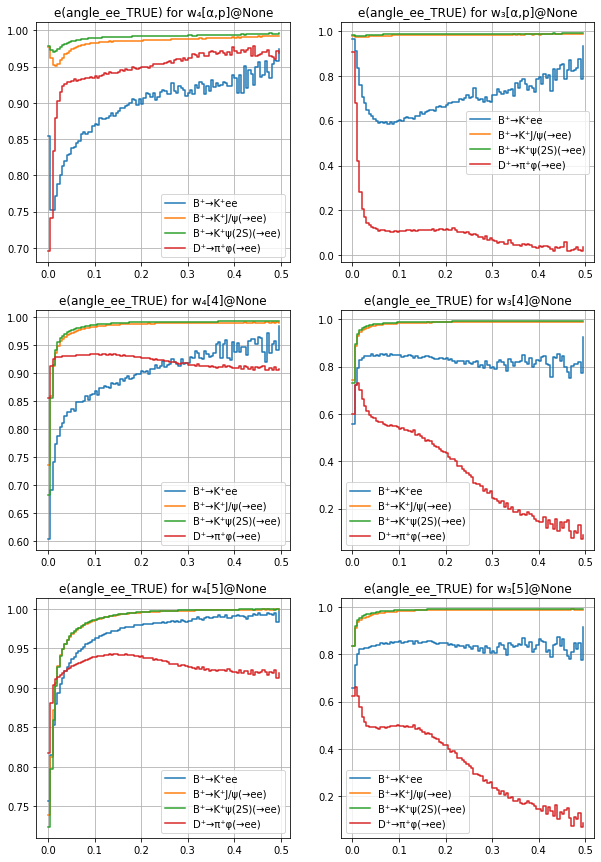

In [78]:
plot_e_all("angle_ee_TRUE", results, np.linspace(0,0.5,101))

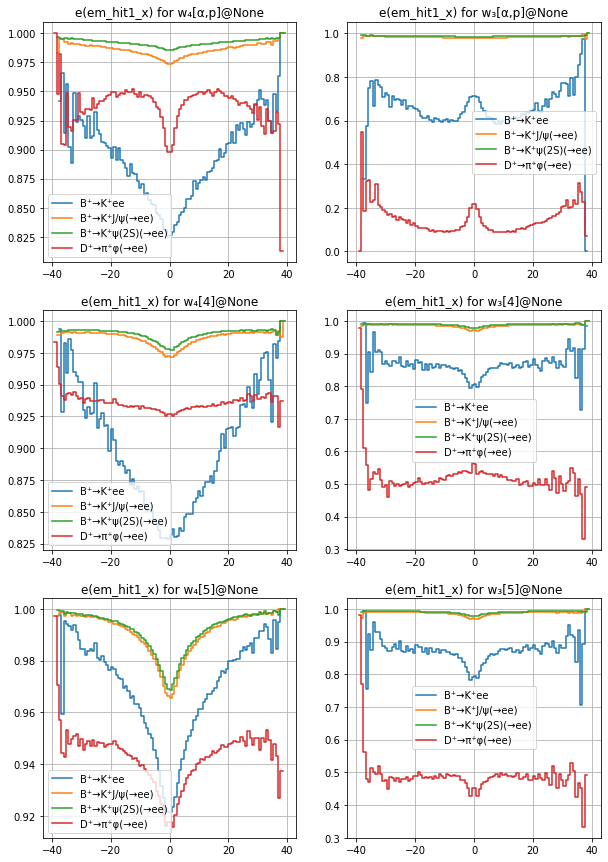

In [79]:
plot_e_all("em_hit1_x", results, np.linspace(-40,40,101))

### Blur

In [80]:
def blur(w, sigma, step=0.01):
    sc = w.model[0]
    
    x_min, y_min = sc.min
    x_max, y_max = sc.max
    
    x1, y1 = sc.transform([[x_min, y_min]])[0]
    x2, y2 = sc.transform([[x_max, y_max]])[0]
    
    xval = np.arange(x1-sigma, x2+sigma, step)
    yval = np.arange(y1-sigma, y2+sigma, step)
    v = np.asarray(np.meshgrid(xval, yval)).reshape(2,-1).transpose()
    X = sc.inverse_transform(v)
    image = as_numpy(w)(X).reshape(yval.size, xval.size)
    print(image.T.shape)
    
    import scipy.ndimage
    filtered = scipy.ndimage.gaussian_filter(image, sigma=sigma/step)
    
    import scipy.interpolate
    inter = scipy.interpolate.interp2d(xval, yval, filtered)
    
    return lambda v : np.asarray([inter(x,y) for x, y in sc.transform(v)])

In [81]:
m = results[None,"₄[α,p]"]
f00 = as_numpy(m.model)
f0 = blur(m, sigma=0.0, step=0.01)
f1 = blur(m, sigma=0.1, step=0.01)
f2 = blur(m, sigma=0.2, step=0.01)
f4 = blur(m, sigma=0.4, step=0.01)

(735, 821)
(755, 841)
(775, 861)
(815, 901)


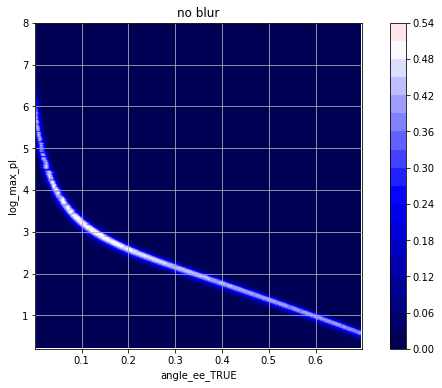

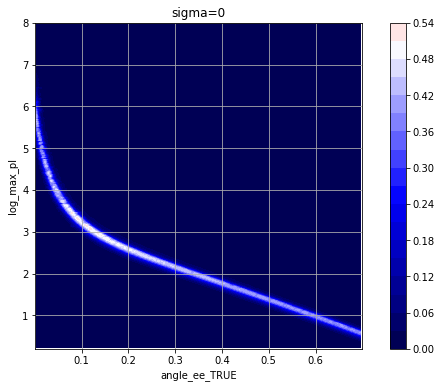

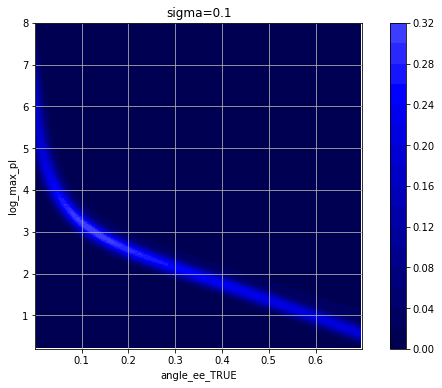

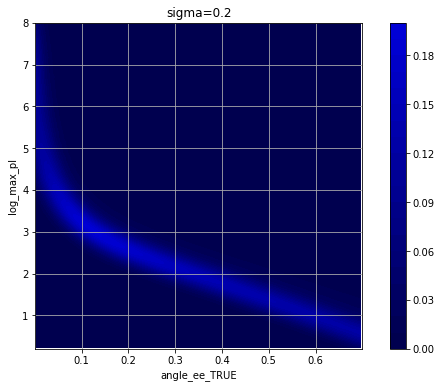

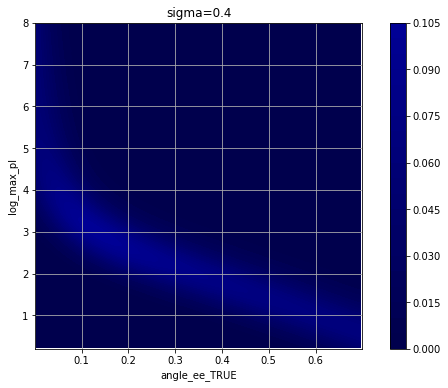

In [82]:
plot_field(f00, m.model[0], name="no blur")
plot_field(f0, m.model[0], name="sigma=0")
plot_field(f1, m.model[0], name="sigma=0.1")
plot_field(f2, m.model[0], name="sigma=0.2")
plot_field(f4, m.model[0], name="sigma=0.4")

In [83]:
def quality_np(datasets, scaler, estimators, refname, name):
    df_w = pd.DataFrame()
    df_w.columns.name = name
    for i, w in enumerate(estimators):
        name1 = "w%s" % i
        r_name = "R%s" % i
        df_w[name1] = None
        for s in datasets:
            ds = Dataset(scaler.features, [s], aliases, name)
            x = to_numpy(ds.X())
            wd = w(x)
            df_w.loc[s.name(),name1] = 1-np.mean(wd).item()
        df_w[r_name] = df_w.loc[refname,name1] / df_w[name1]
    return df_w

In [84]:
quality_np(train_ds, m.model[0], [f00,f0,f1,f2,f4], channel_names[1], "train")

train                  w0        R0        w1        R1        w2        R2  \
B⁺→K⁺ee          0.853702  1.147942  0.853751  1.147824  0.873264  1.101773   
B⁺→K⁺J/ψ(→ee)        0.98       1.0  0.979956       1.0  0.962138       1.0   
B⁺→K⁺ψ(2S)(→ee)  0.988864  0.991036  0.988858  0.990998   0.98198  0.979794   
D⁺→π⁺φ(→ee)          0.93  1.053763  0.930001  1.053715  0.930343  1.034176   

train                  w3        R3        w4        R4  
B⁺→K⁺ee           0.89767  1.058057  0.929007  1.022106  
B⁺→K⁺J/ψ(→ee)    0.949786       1.0  0.949544       1.0  
B⁺→K⁺ψ(2S)(→ee)  0.970279   0.97888  0.960845  0.988238  
D⁺→π⁺φ(→ee)      0.932149  1.018922  0.940962   1.00912